# Changes of cell type abundancies in PBMCs reflects the cancer and treatment effect of proton therapy (all cancers)

---
This notebook summarizes an essential part of the analysis corresponding to the results presented in figure 5 of the paper for all cancer patients. It can be used to rerun the analysis and regenerate the corresponding panels.

---

## 0. Environmental setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import matplotlib as mpl
from matplotlib.collections import PolyCollection
from matplotlib.legend_handler import HandlerTuple
from matplotlib.colors import to_rgb
from collections import Counter

mpl.rcParams["figure.dpi"] = 300

import sys

sys.path.append("../..")
from src.utils.notebooks.eda import *
from src.utils.notebooks.figure3 import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

seed = 1234
random.seed(1234)
np.random.seed(1234)

%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
def get_ct_abundance_data(data, normalize=True):
    ct_abundance_data = {
        "id": [],
        "sample": [],
        "timepoint": [],
        "condition": [],
        "n_pbmc": [],
    }
    all_celltypes_2 = np.unique(data.loc[:, "celltype_2"])
    all_celltypes_3 = np.unique(data.loc[:, "celltype_3"].dropna())
    for idx in np.unique(data.loc[:, "id"]):
        id_data = data.loc[data.id == idx]

        sample_name = np.array(id_data.loc[:, "sample"])[0]
        timepoint = np.array(id_data.loc[:, "timepoint"])[0]
        condition = np.array(id_data.loc[:, "condition"])[0]
        n_pbmc = len(id_data)

        ct_abundance_data["id"].append(idx)
        ct_abundance_data["sample"].append(sample_name)
        ct_abundance_data["timepoint"].append(timepoint)
        ct_abundance_data["condition"].append(condition)
        ct_abundance_data["n_pbmc"].append(n_pbmc)

        for ct in all_celltypes_2:
            if ct not in ct_abundance_data:
                ct_abundance_data[ct] = []
            count = len(id_data.loc[id_data.loc[:, "celltype_2"] == ct])
            if normalize:
                count /= n_pbmc
            ct_abundance_data[ct].append(count)

        for ct in all_celltypes_3:
            if ct not in ct_abundance_data:
                ct_abundance_data[ct] = []
            count = len(id_data.loc[id_data.loc[:, "celltype_3"] == ct])
            if normalize:
                count /= n_pbmc
            ct_abundance_data[ct].append(count)

    return pd.DataFrame(ct_abundance_data)

<IPython.core.display.Javascript object>

In [3]:
def plot_celltype_abundancies_with_control(
    data,
    celltypes,
    celltype_labels=None,
    cut=2,
    figsize=[4, 4],
    plot_type="violin",
    quantiles=None,
    test="Mann-Whitney",
):
    ctrl_colors = [
        "mediumseagreen",
        "mediumseagreen",
        "mediumseagreen",
        "mediumseagreen",
    ]
    mg_colors = ["lightsteelblue", "lightsteelblue", "royalblue", "midnightblue"]
    gl_colors = ["orange", "orange", "gold", "saddlebrown"]
    hn_colors = ["plum", "plum", "deeppink", "indigo"]

    violin_all_colors = ctrl_colors + mg_colors + gl_colors + hn_colors
    bar_all_colors = []
    for i in range(4):
        bar_all_colors.append(ctrl_colors[i])
        bar_all_colors.append(mg_colors[i])
        bar_all_colors.append(gl_colors[i])
        bar_all_colors.append(hn_colors[i])

    for i in range(len(celltypes)):
        fig, ax = plot_marker_distribution(
            data,
            figsize=figsize,
            marker=celltypes[i],
            label_col="condition",
            order=["Control", "Meningioma", "Glioma", "Head & Neck"],
            box_pairs=[
                (("Control", "control"), ("Meningioma", "prior")),
                (("Control", "control"), ("Meningioma", "during")),
                (("Control", "control"), ("Meningioma", "end")),
                (("Control", "control"), ("Glioma", "prior")),
                (("Control", "control"), ("Glioma", "during")),
                (("Control", "control"), ("Glioma", "end")),
                (("Control", "control"), ("Head & Neck", "prior")),
                (("Control", "control"), ("Head & Neck", "during")),
                (("Control", "control"), ("Head & Neck", "end")),
                (("Meningioma", "prior"), ("Meningioma", "during")),
                (("Meningioma", "prior"), ("Meningioma", "end")),
                (("Meningioma", "during"), ("Meningioma", "end")),
                (("Glioma", "prior"), ("Glioma", "during")),
                (("Glioma", "prior"), ("Glioma", "end")),
                (("Glioma", "during"), ("Glioma", "end")),
                (("Head & Neck", "prior"), ("Head & Neck", "during")),
                (("Head & Neck", "prior"), ("Head & Neck", "end")),
                (("Head & Neck", "during"), ("Head & Neck", "end")),
            ],
            quantiles=quantiles,
            cut=cut,
            plot_type=plot_type,
            palette="gray",
            hue="timepoint",
            hue_order=["control", "prior", "during", "end"],
            test=test,
        )
        ax.set_xlabel("Condition")
        if celltype_labels is not None:
            ax.set_ylabel(celltype_labels[i])

        handles = []
        if plot_type == "violin":
            for ind, obj in enumerate(ax.findobj(PolyCollection)):
                rgb = to_rgb(violin_all_colors[ind])
                obj.set_facecolor(rgb)
                handles.append(
                    plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor="black")
                )
        elif plot_type == "bar":
            for ind, bar in enumerate(ax.patches):
                rgb = to_rgb(bar_all_colors[ind])
                bar.set_color(rgb)
                handles_color = to_rgb(violin_all_colors[ind])
                handles.append(
                    plt.Rectangle(
                        (0, 0), 0, 0, facecolor=handles_color, edgecolor="black"
                    )
                )
        else:
            raise NotImplementedError

        ax.legend(
            handles=[
                tuple(handles[1:4]),
                tuple(handles[5::4]),
                tuple(handles[6::4]),
                tuple(handles[7::4]),
            ],
            labels=tp_order,
            title="Timepoint",
            handlelength=4,
            handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
            bbox_to_anchor=(1.02, 0.5),
            loc="center left",
            borderaxespad=0,
        )

        plt.show()
        plt.close()

<IPython.core.display.Javascript object>

In [4]:
def plot_celltype_abundancies(
    data,
    celltypes,
    celltype_labels=None,
    cut=2,
    figsize=[4, 4],
    plot_type="violin",
    quantiles=None,
    test="Mann-Whitney",
):

    mg_colors = ["lightsteelblue", "royalblue", "midnightblue"]
    gl_colors = ["orange", "gold", "saddlebrown"]
    hn_colors = ["plum", "deeppink", "indigo"]

    violin_all_colors = mg_colors + gl_colors + hn_colors
    bar_all_colors = []
    for i in range(3):

        bar_all_colors.append(mg_colors[i])
        bar_all_colors.append(gl_colors[i])
        bar_all_colors.append(hn_colors[i])

    for i in range(len(celltypes)):
        fig, ax = plot_marker_distribution(
            data,
            figsize=figsize,
            marker=celltypes[i],
            label_col="condition",
            order=["Meningioma", "Glioma", "Head & Neck"],
            box_pairs=[
                (("Meningioma", "prior"), ("Meningioma", "during")),
                (("Meningioma", "prior"), ("Meningioma", "end")),
                (("Meningioma", "during"), ("Meningioma", "end")),
                (("Glioma", "prior"), ("Glioma", "during")),
                (("Glioma", "prior"), ("Glioma", "end")),
                (("Glioma", "during"), ("Glioma", "end")),
                (("Head & Neck", "prior"), ("Head & Neck", "during")),
                (("Head & Neck", "prior"), ("Head & Neck", "end")),
                (("Head & Neck", "during"), ("Head & Neck", "end")),
            ],
            stat_annot="star",
            quantiles=quantiles,
            cut=cut,
            plot_type=plot_type,
            palette="gray",
            hue="timepoint",
            hue_order=["prior", "during", "end"],
            test=test,
        )
        ax.set_xlabel("Condition")
        if celltype_labels is not None:
            ax.set_ylabel(celltype_labels[i])

        handles = []
        if plot_type == "violin":
            for ind, obj in enumerate(ax.findobj(PolyCollection)):
                rgb = to_rgb(violin_all_colors[ind])
                obj.set_facecolor(rgb)
                handles.append(
                    plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor="black")
                )
        elif plot_type == "bar":
            for ind, bar in enumerate(ax.patches):
                rgb = to_rgb(bar_all_colors[ind])
                bar.set_color(rgb)
                handles_color = to_rgb(violin_all_colors[ind])
                handles.append(
                    plt.Rectangle(
                        (0, 0), 0, 0, facecolor=handles_color, edgecolor="black"
                    )
                )
        else:
            raise NotImplementedError

        ax.legend(
            handles=[
                tuple(handles[0::3]),
                tuple(handles[1::3]),
                tuple(handles[2::3]),
            ],
            labels=tp_order,
            title="Timepoint",
            handlelength=4,
            handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
            bbox_to_anchor=(1.02, 0.5),
            loc="center left",
            borderaxespad=0,
        )

        plt.show()
        plt.close()

<IPython.core.display.Javascript object>

In [5]:
cond_palette = {
    "Control": "mediumseagreen",
    "Meningioma": "cornflowerblue",
    "Glioma": "orange",
    "Head & Neck": "orchid",
}

<IPython.core.display.Javascript object>

In [6]:
mg_colors = ["lightsteelblue", "royalblue", "midnightblue"]
gl_colors = ["orange", "gold", "saddlebrown"]
hn_colors = ["plum", "deeppink", "indigo"]



<IPython.core.display.Javascript object>

---

## 1. Read in data

In this notebook we assess the differences of the abundancies of the different subsets of PBMCs at three different time points of the proton therapy treatment: before, during (~3 weeks in) and at the end of the treatment (final week of treatment). To this end, we obtained PBMCs of 8 Meningioma, 8 Glioma and 6 Head & Neck cancer patients stained them for DNA, CD16, CD4 and CD8 and obtained fluorescent images. Additionally, we will use a set of 8 healthy control patients for which we have stained the PBMCs for CD4 and CD8 to compare the abundancies of the corresponding subtypes of PBMCs of our treatment population to healthy controls.

First, we read in the required data set that describe each PBMCs by a number of hand-crafted features extracted from the fluorescent images of the cells.

In [7]:
feature_file_path = "/preprocessed/full_pipeline/nuclear_features.csv"
qc_result_file_path = "/preprocessed/full_pipeline/segmentation/qc_results.csv"
marker_label_file_path = "/preprocessed/full_pipeline/marker_labels/marker_labels.csv"

<IPython.core.display.Javascript object>

#### Healthy controls

In [8]:
ctrl_root_data_dir = "../../data/control/marker"

ctrl_data = read_in_marker_dataset(
    data_dir=ctrl_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    marker_label_file_path=marker_label_file_path,
)
ctrl_data["id"] = ctrl_data["sample"]
ctrl_data["timepoint"] = "control"
ctrl_data["condition"] = "Control"
ctrl_data["file_name"] = np.array(list(ctrl_data.index))

Load data: 100%|██████████| 8/8 [00:00<00:00, 31.84it/s]


<IPython.core.display.Javascript object>

#### Meningioma

In [9]:
mg_tp1_root_data_dir = "../../data/meningioma/marker/timepoint_1"

mg_tp1_data = read_in_marker_dataset(
    data_dir=mg_tp1_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    marker_label_file_path=marker_label_file_path,
)
mg_tp1_data["id"] = mg_tp1_data["sample"] + mg_tp1_data["timepoint"]
mg_tp1_data["timepoint"] = "prior"
mg_tp1_data["condition"] = "Meningioma"
mg_tp1_data["file_name"] = np.array(list(mg_tp1_data.index))

Load data: 100%|██████████| 10/10 [00:00<00:00, 24.25it/s]


<IPython.core.display.Javascript object>

In [10]:
mg_tp2_root_data_dir = "../../data/meningioma/marker/timepoint_2"

mg_tp2_data = read_in_marker_dataset(
    data_dir=mg_tp2_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    marker_label_file_path=marker_label_file_path,
)
mg_tp2_data["id"] = mg_tp2_data["sample"] + mg_tp2_data["timepoint"]
mg_tp2_data["timepoint"] = "during"
mg_tp2_data["condition"] = "Meningioma"
mg_tp2_data["file_name"] = np.array(list(mg_tp2_data.index))

Load data: 100%|██████████| 10/10 [00:00<00:00, 26.47it/s]


<IPython.core.display.Javascript object>

In [11]:
mg_tp3_root_data_dir = "../../data/meningioma/marker/timepoint_3"

mg_tp3_data = read_in_marker_dataset(
    data_dir=mg_tp3_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    marker_label_file_path=marker_label_file_path,
)
mg_tp3_data["id"] = mg_tp3_data["sample"] + mg_tp3_data["timepoint"]
mg_tp3_data["timepoint"] = "end"
mg_tp3_data["condition"] = "Meningioma"
mg_tp3_data["file_name"] = np.array(list(mg_tp3_data.index))

Load data: 100%|██████████| 10/10 [00:00<00:00, 24.89it/s]


<IPython.core.display.Javascript object>

---

#### Glioma

In [12]:
gl_tp1_root_data_dir = "../../data/glioma/marker/timepoint_1"

gl_tp1_data = read_in_marker_dataset(
    data_dir=gl_tp1_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    marker_label_file_path=marker_label_file_path,
)
gl_tp1_data["id"] = gl_tp1_data["sample"] + gl_tp1_data["timepoint"]
gl_tp1_data["timepoint"] = "prior"
gl_tp1_data["condition"] = "Glioma"
gl_tp1_data["file_name"] = np.array(list(gl_tp1_data.index))

Load data: 100%|██████████| 10/10 [00:00<00:00, 29.50it/s]


<IPython.core.display.Javascript object>

In [13]:
gl_tp2_root_data_dir = "../../data/glioma/marker/timepoint_2"

gl_tp2_data = read_in_marker_dataset(
    data_dir=gl_tp2_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    marker_label_file_path=marker_label_file_path,
)
gl_tp2_data["id"] = gl_tp2_data["sample"] + gl_tp2_data["timepoint"]
gl_tp2_data["timepoint"] = "during"
gl_tp2_data["condition"] = "Glioma"
gl_tp2_data["file_name"] = np.array(list(gl_tp2_data.index))

Load data: 100%|██████████| 10/10 [00:00<00:00, 26.46it/s]


<IPython.core.display.Javascript object>

In [14]:
gl_tp3_root_data_dir = "../../data/glioma/marker/timepoint_3"

gl_tp3_data = read_in_marker_dataset(
    data_dir=gl_tp3_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    marker_label_file_path=marker_label_file_path,
)
gl_tp3_data["id"] = gl_tp3_data["sample"] + gl_tp3_data["timepoint"]
gl_tp3_data["timepoint"] = "end"
gl_tp3_data["condition"] = "Glioma"
gl_tp3_data["file_name"] = np.array(list(gl_tp3_data.index))

Load data: 100%|██████████| 10/10 [00:00<00:00, 27.28it/s]


<IPython.core.display.Javascript object>

---

#### Head & Neck cancers

In [15]:
hn_tp1_root_data_dir = "../../data/headneck/marker/timepoint_1"

hn_tp1_data = read_in_marker_dataset(
    data_dir=hn_tp1_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    marker_label_file_path=marker_label_file_path,
)
hn_tp1_data["id"] = hn_tp1_data["sample"] + hn_tp1_data["timepoint"]
hn_tp1_data["timepoint"] = "prior"
hn_tp1_data["condition"] = "Head & Neck"
hn_tp1_data["file_name"] = np.array(list(hn_tp1_data.index))

Load data: 100%|██████████| 10/10 [00:00<00:00, 25.47it/s]


<IPython.core.display.Javascript object>

In [16]:
hn_tp2_root_data_dir = "../../data/headneck/marker/timepoint_2"

hn_tp2_data = read_in_marker_dataset(
    data_dir=hn_tp2_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    marker_label_file_path=marker_label_file_path,
)
hn_tp2_data["id"] = hn_tp2_data["sample"] + hn_tp2_data["timepoint"]
hn_tp2_data["timepoint"] = "during"
hn_tp2_data["condition"] = "Head & Neck"
hn_tp2_data["file_name"] = np.array(list(hn_tp2_data.index))

Load data: 100%|██████████| 10/10 [00:00<00:00, 31.03it/s]


<IPython.core.display.Javascript object>

In [17]:
hn_tp3_root_data_dir = "../../data/headneck/marker/timepoint_3"

hn_tp3_data = read_in_marker_dataset(
    data_dir=hn_tp3_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    marker_label_file_path=marker_label_file_path,
)
hn_tp3_data["id"] = hn_tp3_data["sample"] + hn_tp3_data["timepoint"]
hn_tp3_data["timepoint"] = "end"
hn_tp3_data["condition"] = "Head & Neck"
hn_tp3_data["file_name"] = np.array(list(hn_tp3_data.index))

Load data: 100%|██████████| 10/10 [00:00<00:00, 25.13it/s]


<IPython.core.display.Javascript object>

---

## 2. Data preprocessing

Before we analyze the data, we will first preprocess it.

To this end, we first remove features with missing values and samples with missing features.

In [18]:
ctrl_data = preprocess_data(ctrl_data, remove_constant_features=False)

mg_tp1_data = preprocess_data(mg_tp1_data, remove_constant_features=False)
mg_tp2_data = preprocess_data(mg_tp2_data, remove_constant_features=False)
mg_tp3_data = preprocess_data(mg_tp3_data, remove_constant_features=False)

gl_tp1_data = preprocess_data(gl_tp1_data, remove_constant_features=False)
gl_tp2_data = preprocess_data(gl_tp2_data, remove_constant_features=False)
gl_tp3_data = preprocess_data(gl_tp3_data, remove_constant_features=False)

hn_tp1_data = preprocess_data(hn_tp1_data, remove_constant_features=False)
hn_tp2_data = preprocess_data(hn_tp2_data, remove_constant_features=False)
hn_tp3_data = preprocess_data(hn_tp3_data, remove_constant_features=False)

all_data = (
    ctrl_data.append(mg_tp1_data)
    .append(gl_tp1_data)
    .append(hn_tp1_data)
    .append(mg_tp2_data)
    .append(gl_tp2_data)
    .append(hn_tp2_data)
    .append(mg_tp3_data)
    .append(gl_tp3_data)
    .append(hn_tp3_data)
)
all_data.index = all_data["id"] + "_" + all_data.index

Nuclei that did not pass the quality check: 113/2354. Remaining: 2241.
Removed 9 constant or features with missing values. Remaining: 275.
Removed additional 6 features. Remaining: 269.
Nuclei that did not pass the quality check: 364/5104. Remaining: 4740.
Removed 12 constant or features with missing values. Remaining: 293.
Removed additional 6 features. Remaining: 287.
Nuclei that did not pass the quality check: 272/4965. Remaining: 4693.
Removed 12 constant or features with missing values. Remaining: 293.
Removed additional 6 features. Remaining: 287.
Nuclei that did not pass the quality check: 168/5779. Remaining: 5611.
Removed 9 constant or features with missing values. Remaining: 296.
Removed additional 6 features. Remaining: 290.
Nuclei that did not pass the quality check: 317/5211. Remaining: 4894.
Removed 12 constant or features with missing values. Remaining: 293.
Removed additional 6 features. Remaining: 287.
Nuclei that did not pass the quality check: 352/5217. Remaining: 48

<IPython.core.display.Javascript object>

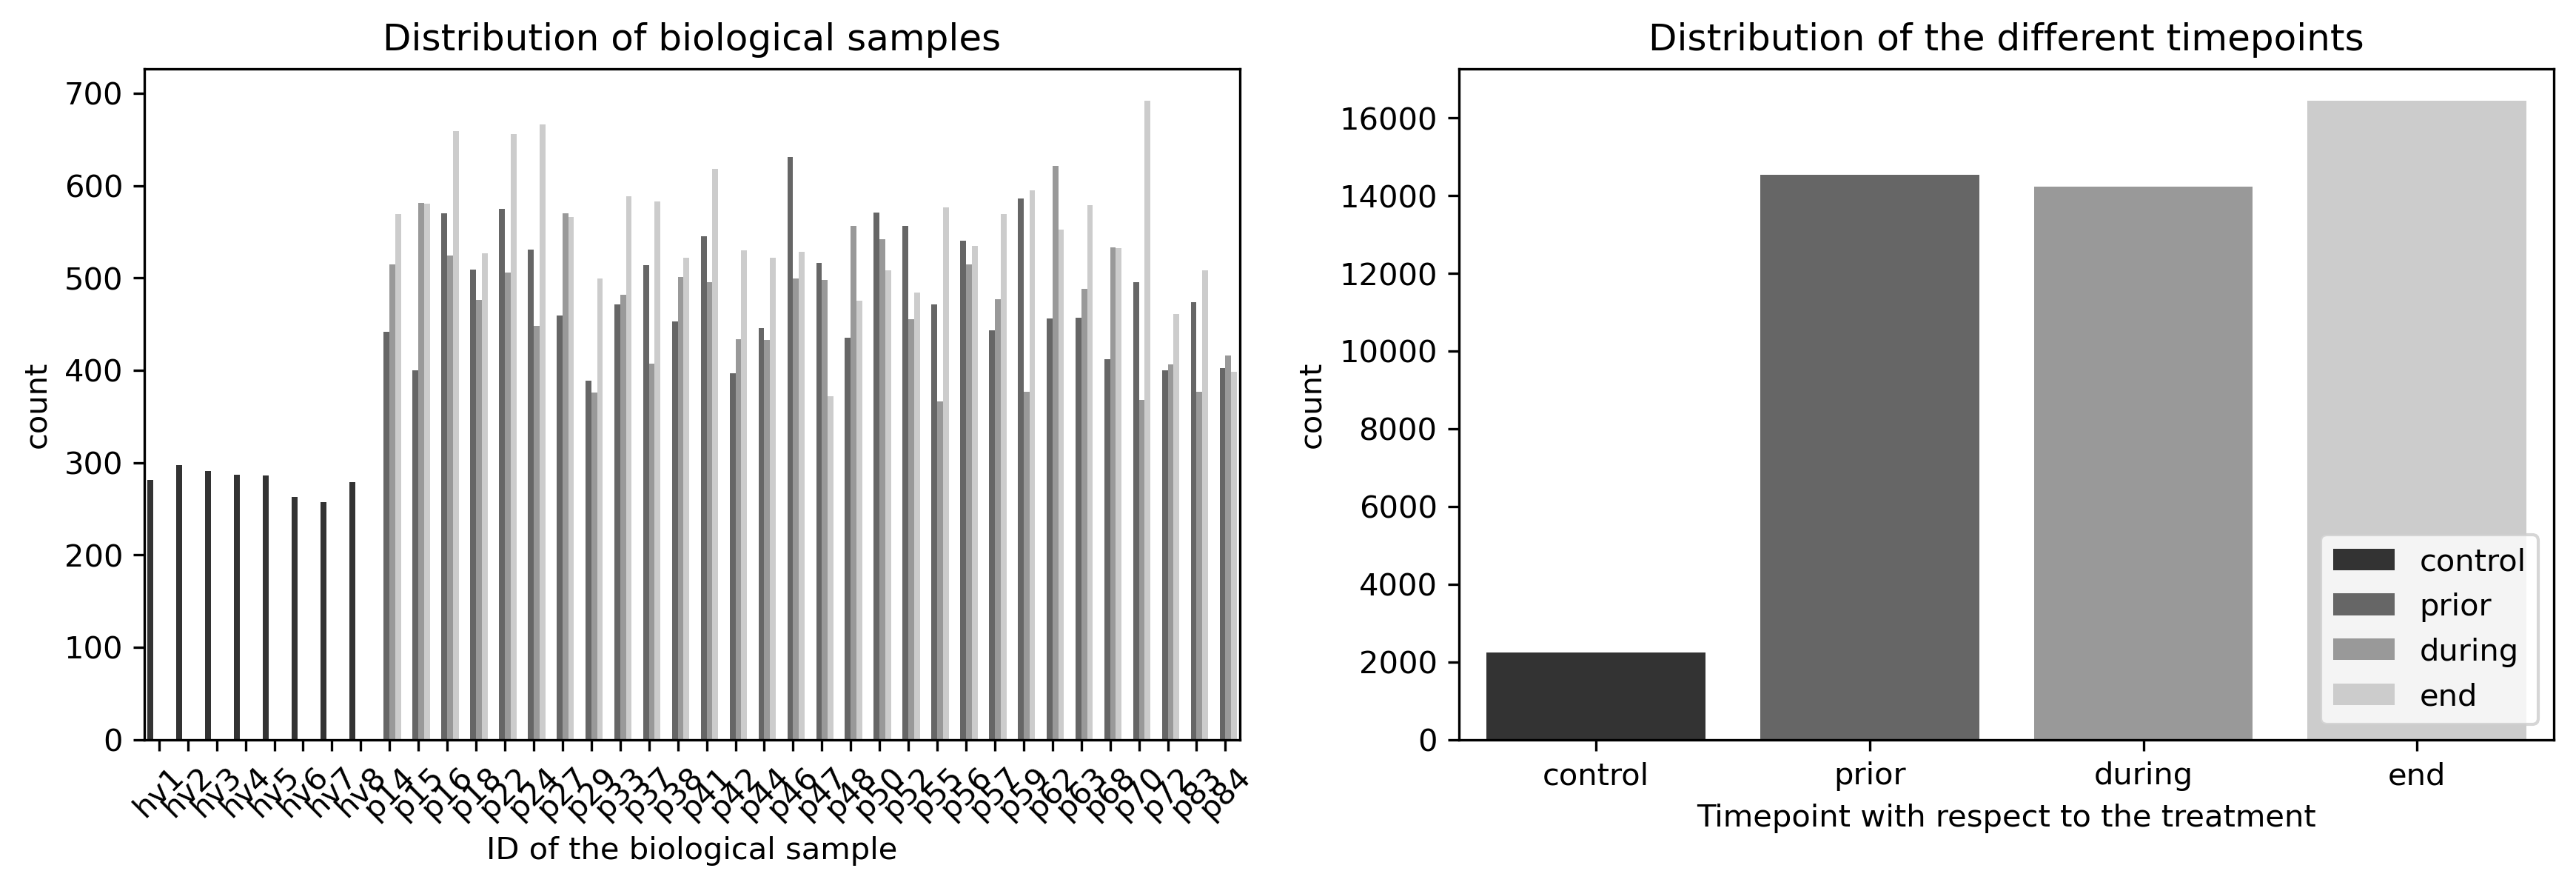

<IPython.core.display.Javascript object>

In [19]:
fig, ax = plt.subplots(figsize=[14, 4], ncols=2)
tp_order = ["control", "prior", "during", "end"]
sample_order = np.unique(all_data.loc[:, "sample"])
ax = ax.flatten()
ax[0] = sns.countplot(
    x="sample",
    data=all_data,
    ax=ax[0],
    order=sample_order,
    hue_order=tp_order,
    hue="timepoint",
    palette="gray",
)
ax[0].legend([], [], frameon=False)
ax[0].set_xlabel("ID of the biological sample")
ax[0].set_title("Distribution of biological samples")
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)

ax[1] = sns.countplot(
    x="timepoint",
    hue="timepoint",
    data=all_data,
    ax=ax[1],
    order=tp_order,
    dodge=False,
    palette="gray",
)
ax[1].set_xlabel("Timepoint with respect to the treatment")
ax[1].set_title("Distribution of the different timepoints")
ax[1].legend(loc="lower right")

plt.show()
plt.close()

### Add cell type labels

We will now add combined cell type labels for all nuclei.

In [20]:
data = all_data.copy()
celltype_cols = ["cd4", "cd8", "cd16"]
coding_dict = {0: "-", 1: "+"}
for celltype_col in celltype_cols:
    data.loc[:, celltype_col] = data.loc[:, celltype_col].map(coding_dict)

data["celltype_2"] = "CD4" + data["cd4"] + "CD8" + data["cd8"]
data["celltype_3"] = data["celltype_2"] + "CD16" + data["cd16"]
celltypes_2 = np.unique(data.loc[:, "celltype_2"])
celltypes_3 = np.unique(data.loc[:, "celltype_3"].dropna())

<IPython.core.display.Javascript object>

In [21]:
ct_abundance_data = get_ct_abundance_data(data, normalize=True)

<IPython.core.display.Javascript object>

As a first step let us have a look for each sample individually at the cell type distribution.

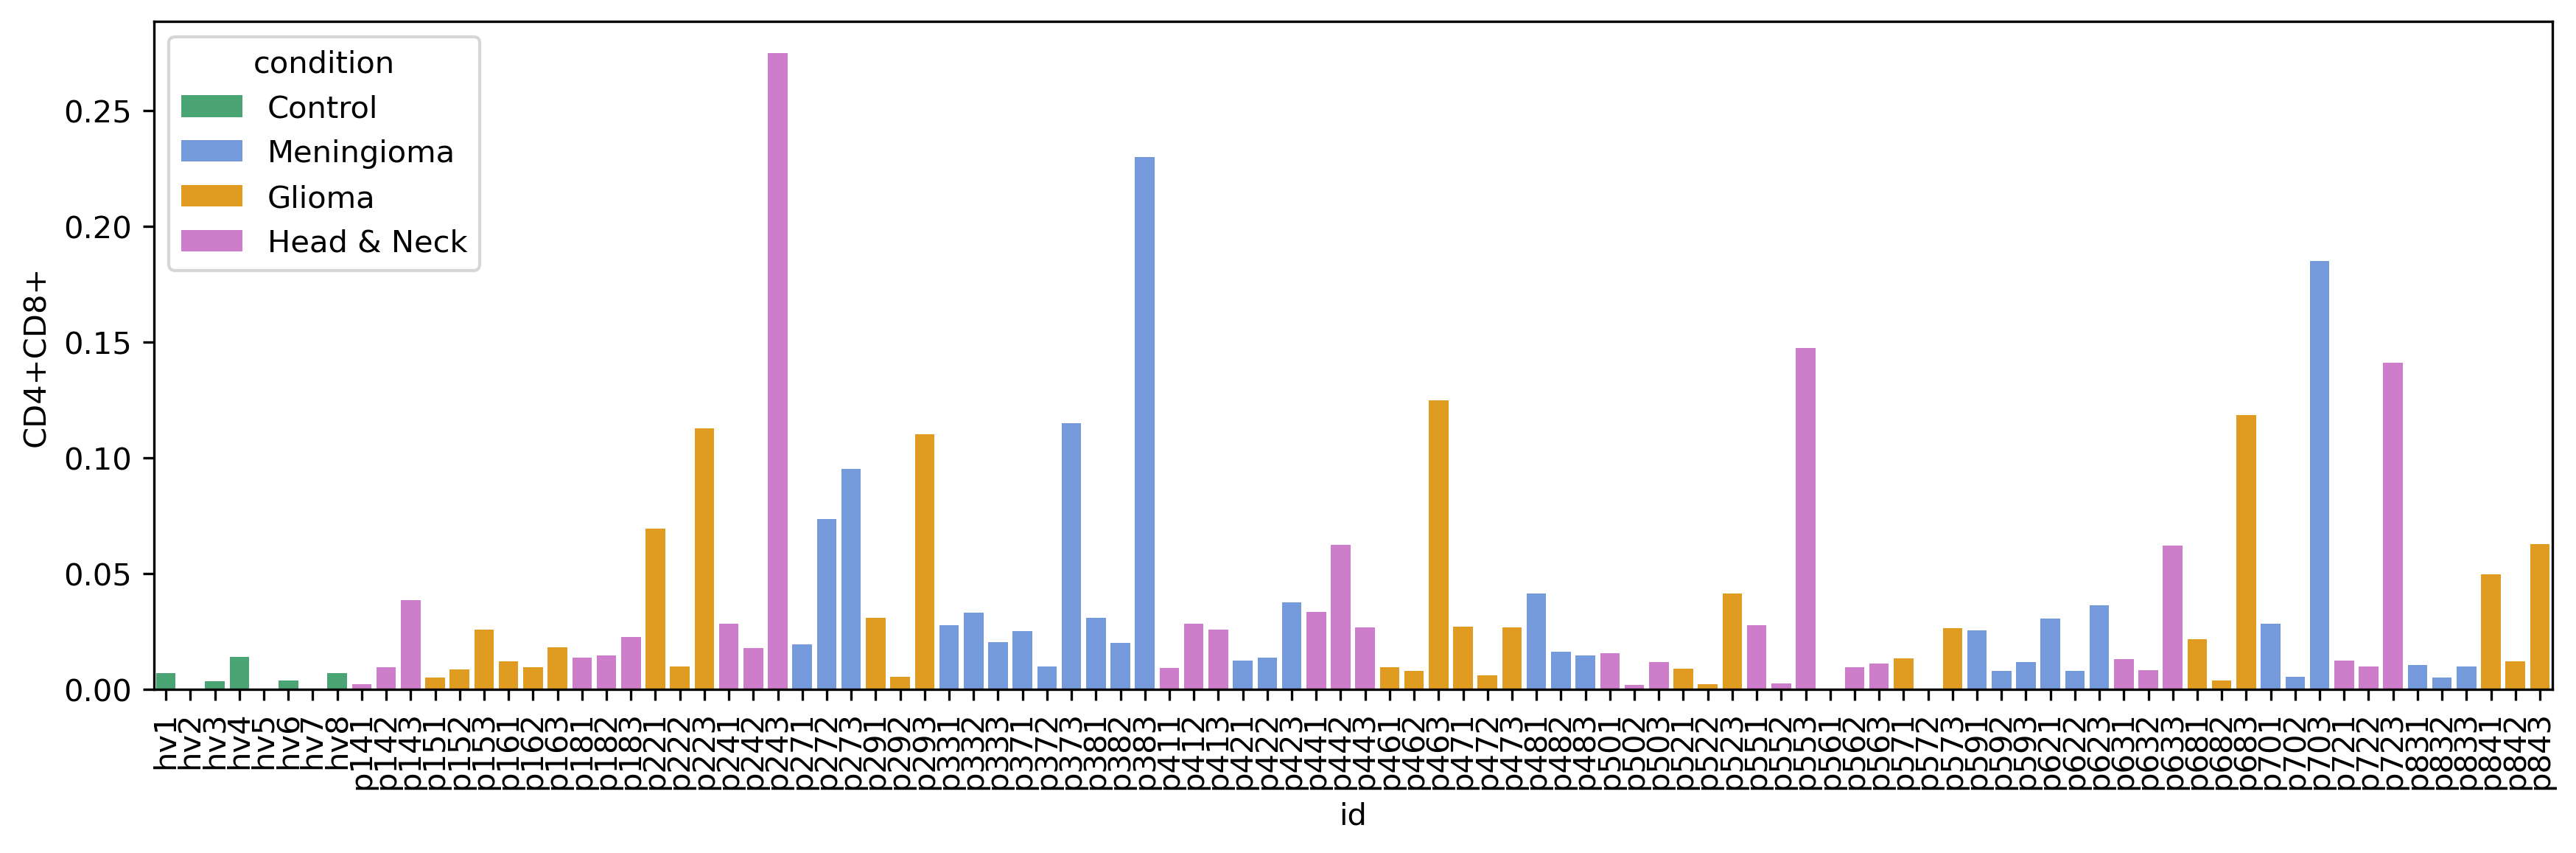

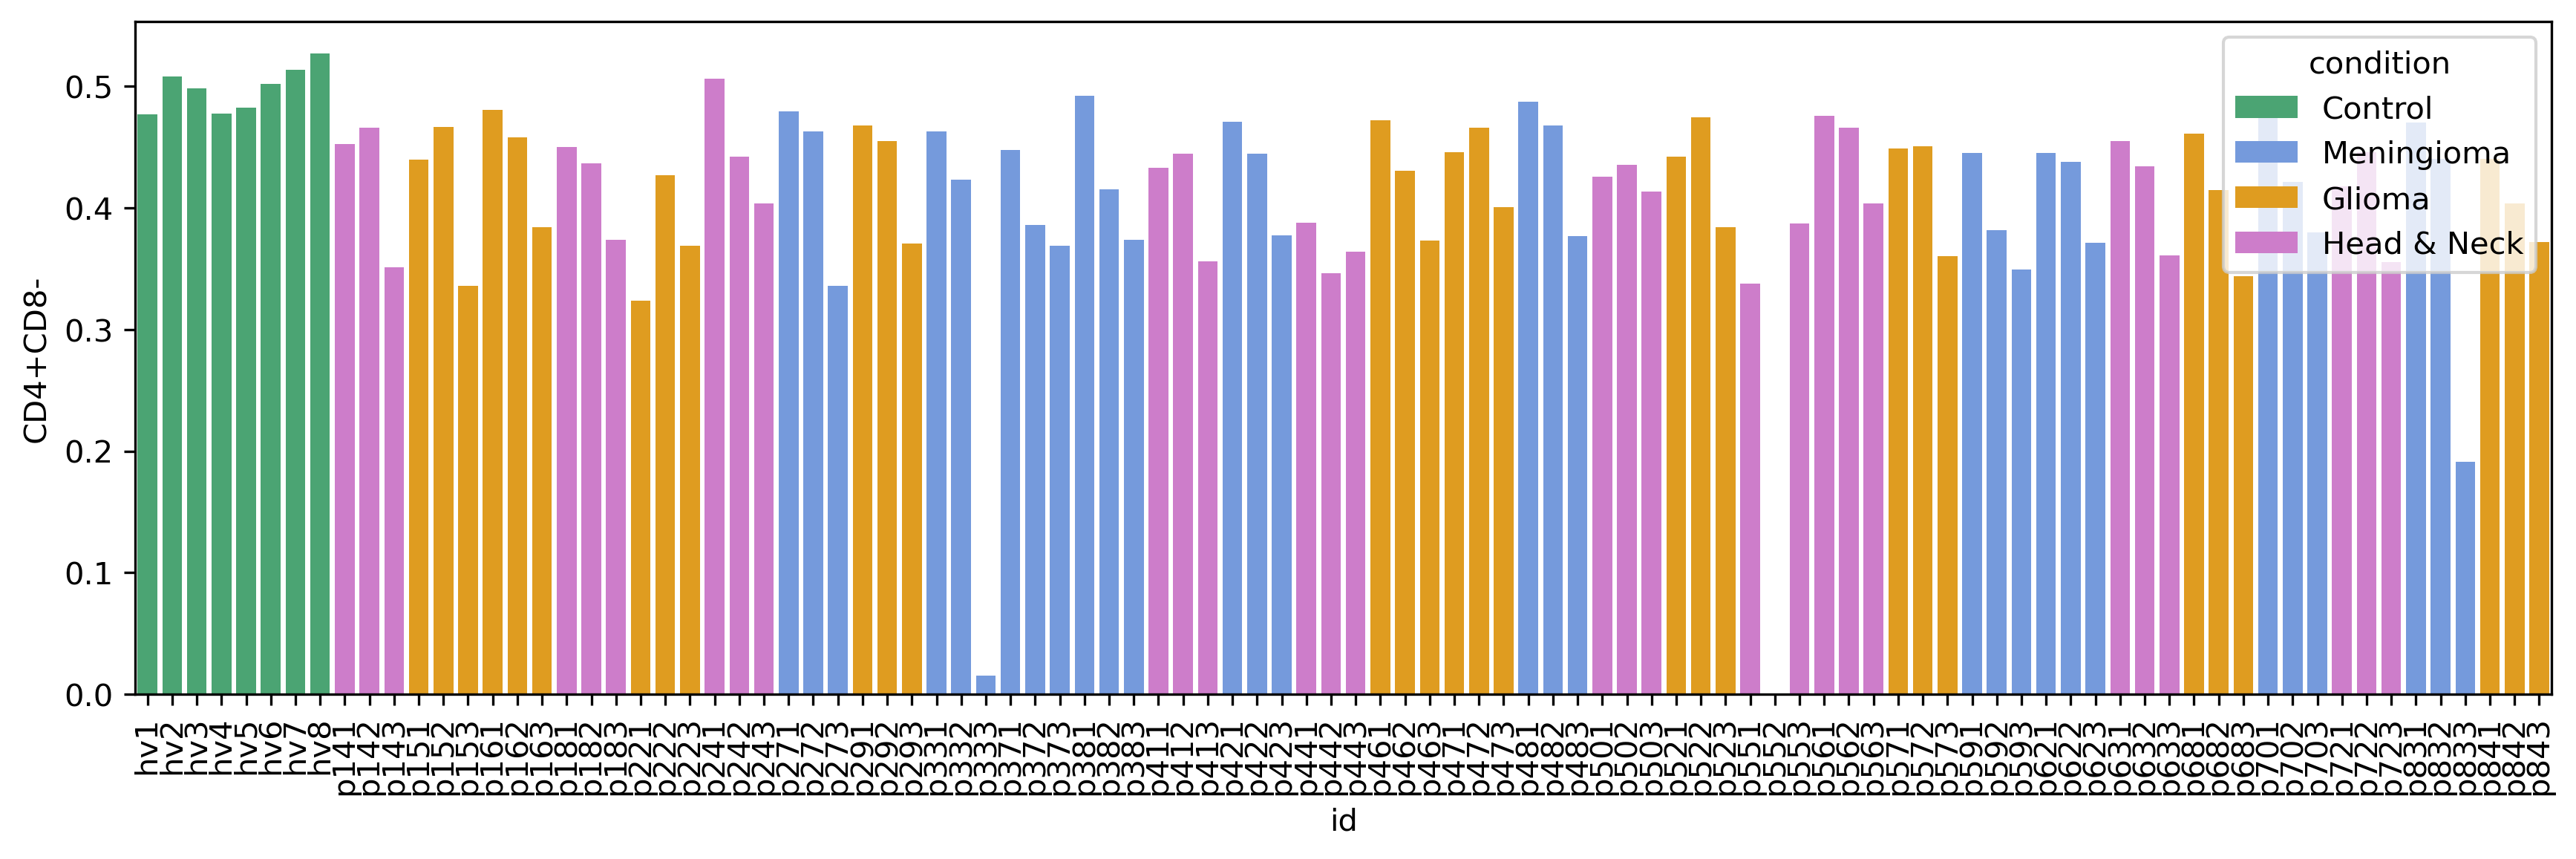

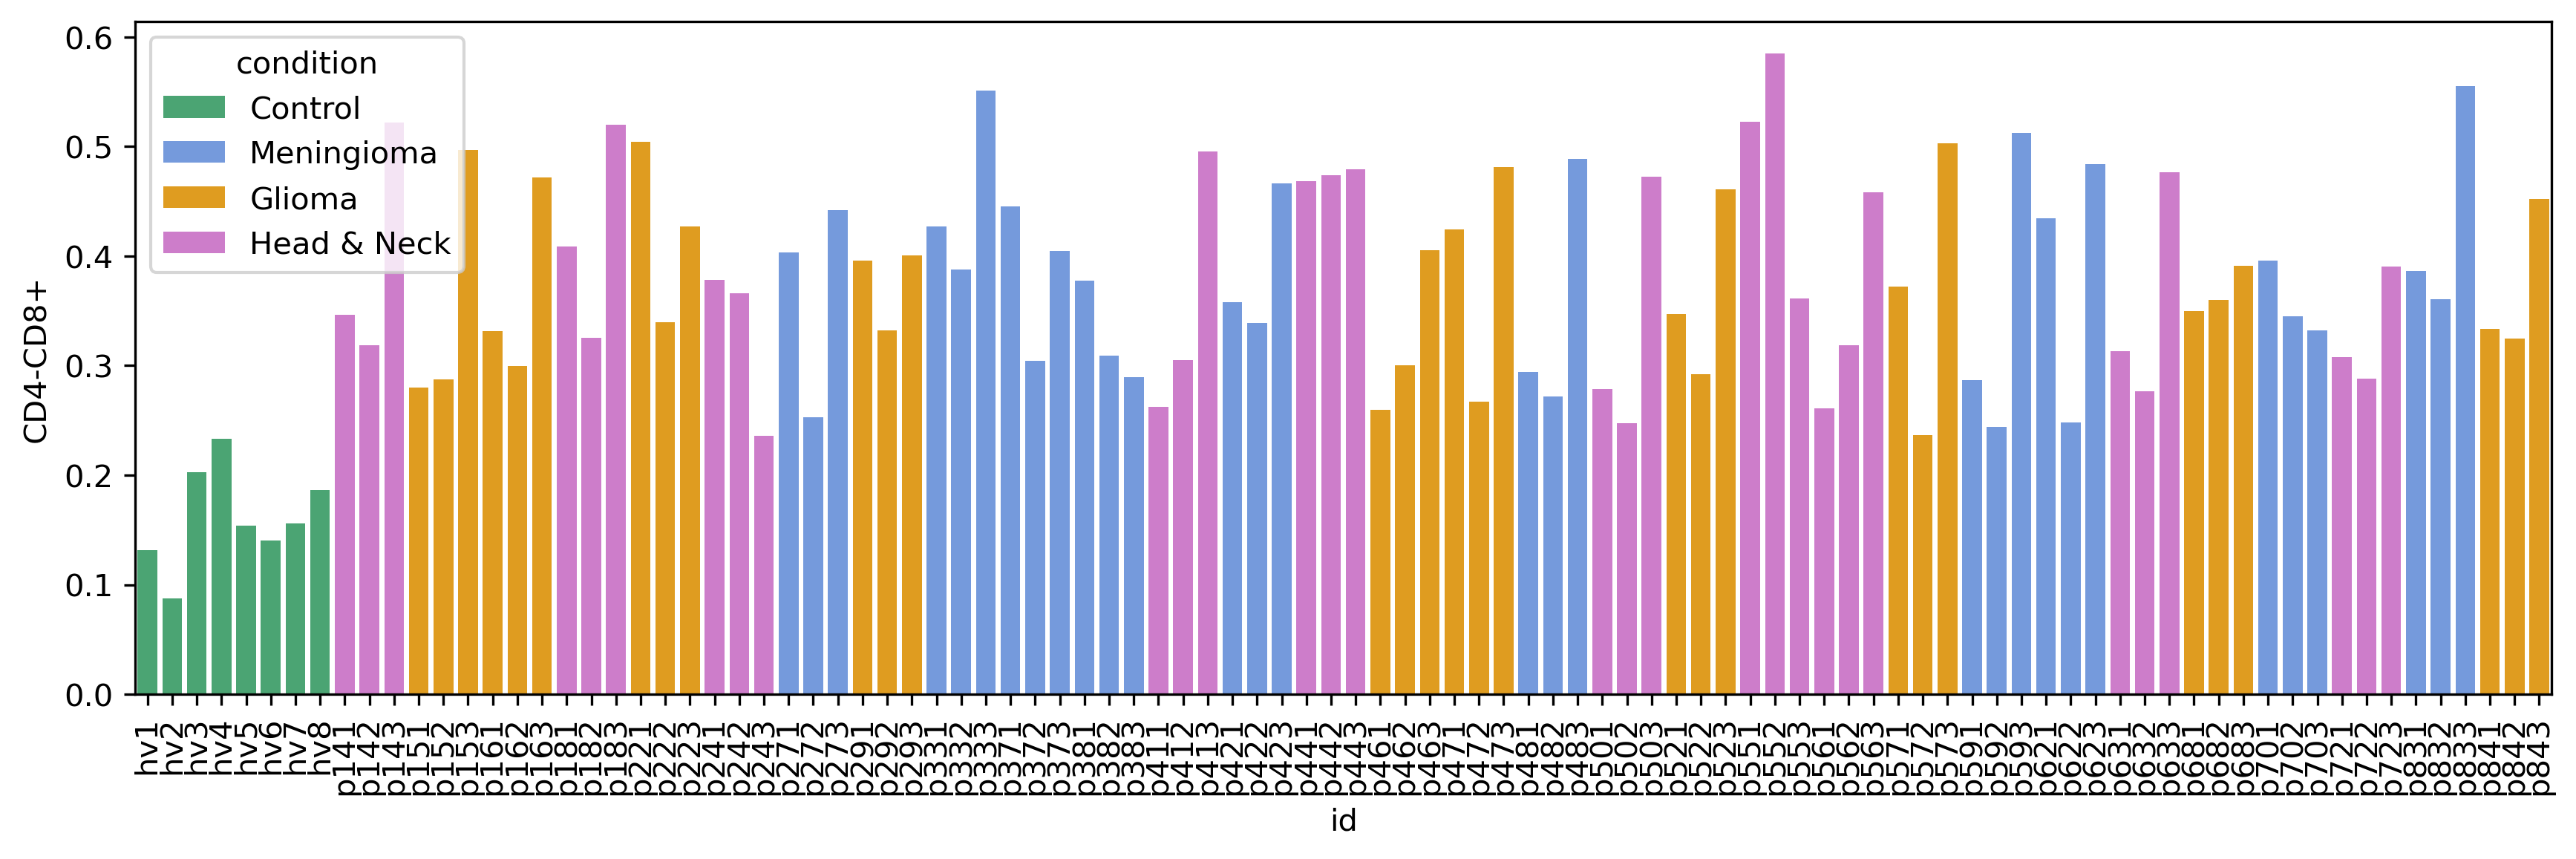

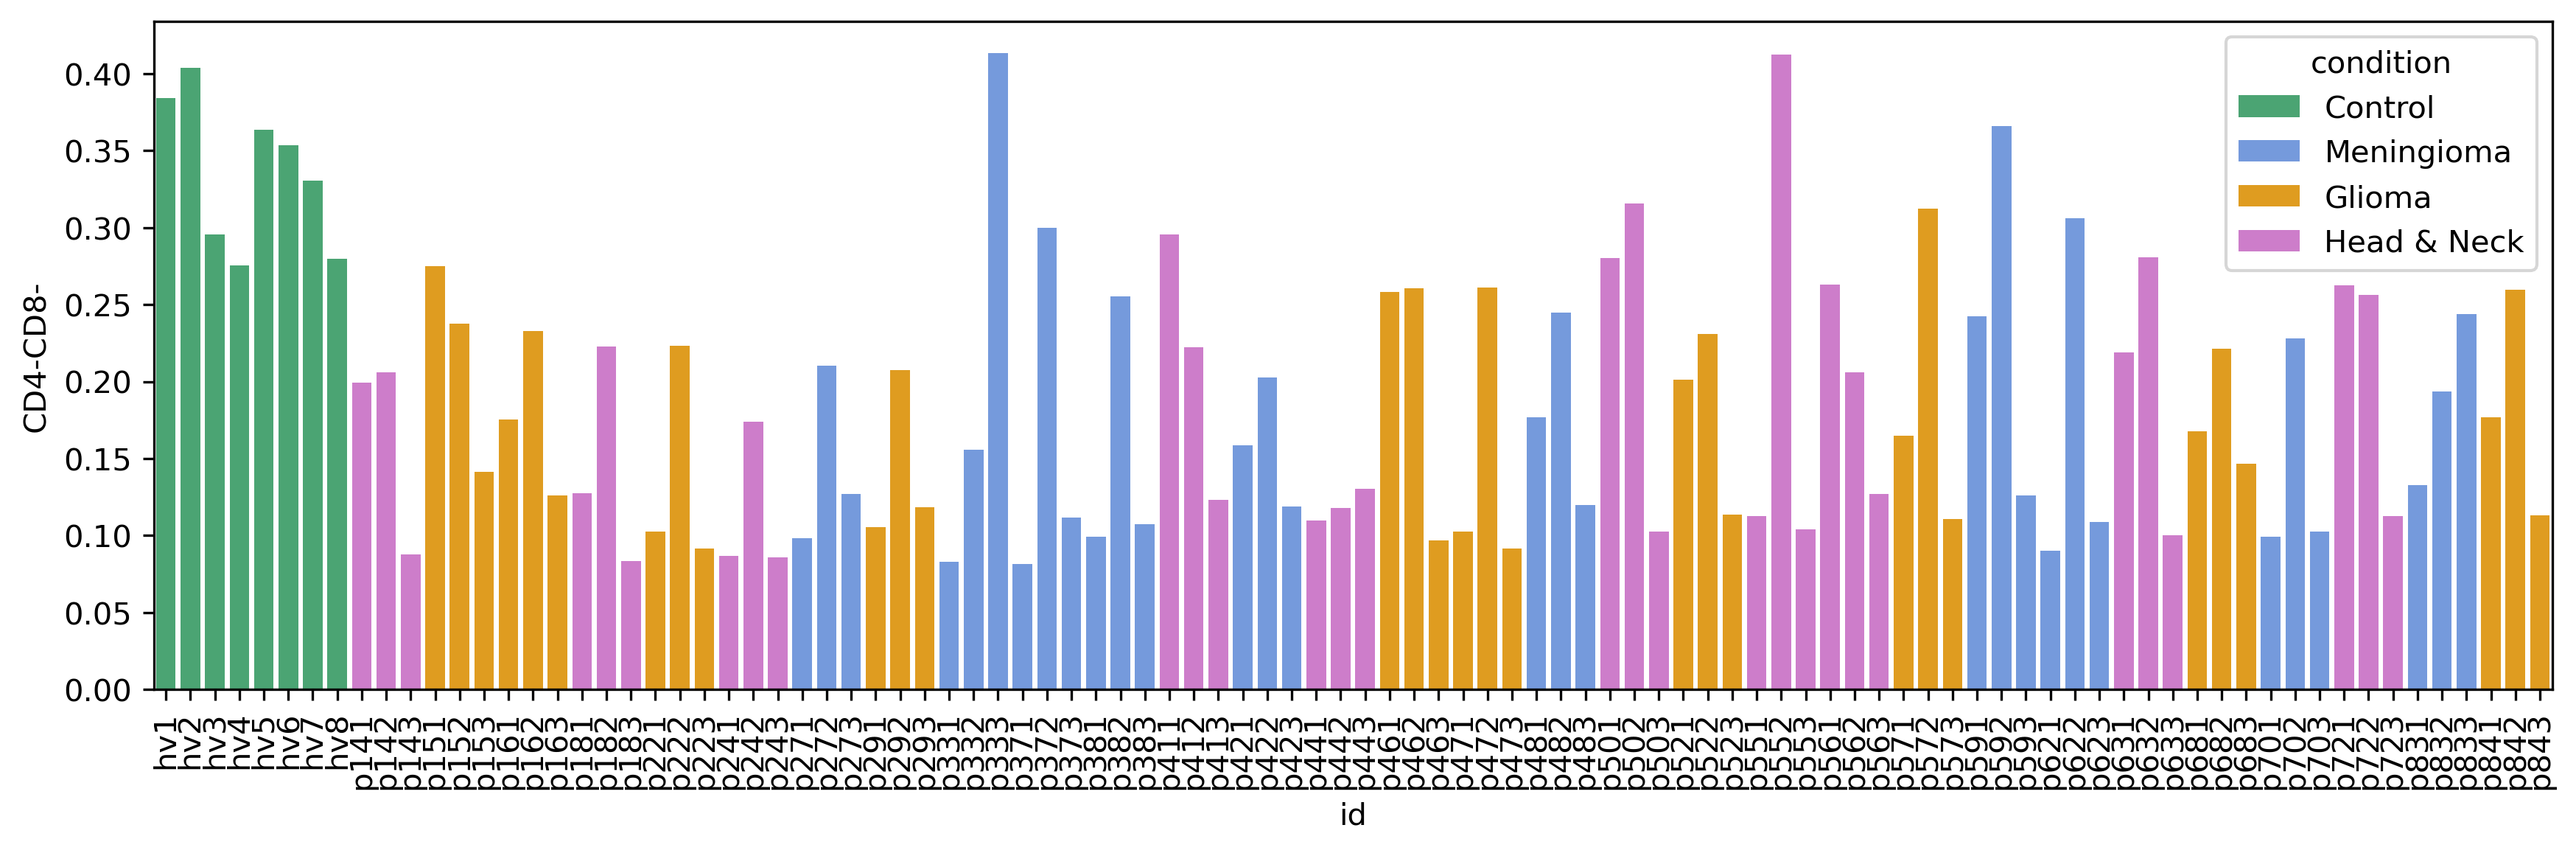

<IPython.core.display.Javascript object>

In [22]:
for celltype in celltypes_2:
    fig, ax = plt.subplots(figsize=[14, 4])
    ax = sns.barplot(
        data=ct_abundance_data,
        x="id",
        y=celltype,
        ax=ax,
        hue="condition",
        hue_order=list(cond_palette.keys()),
        palette=cond_palette,
        dodge=False,
    )
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

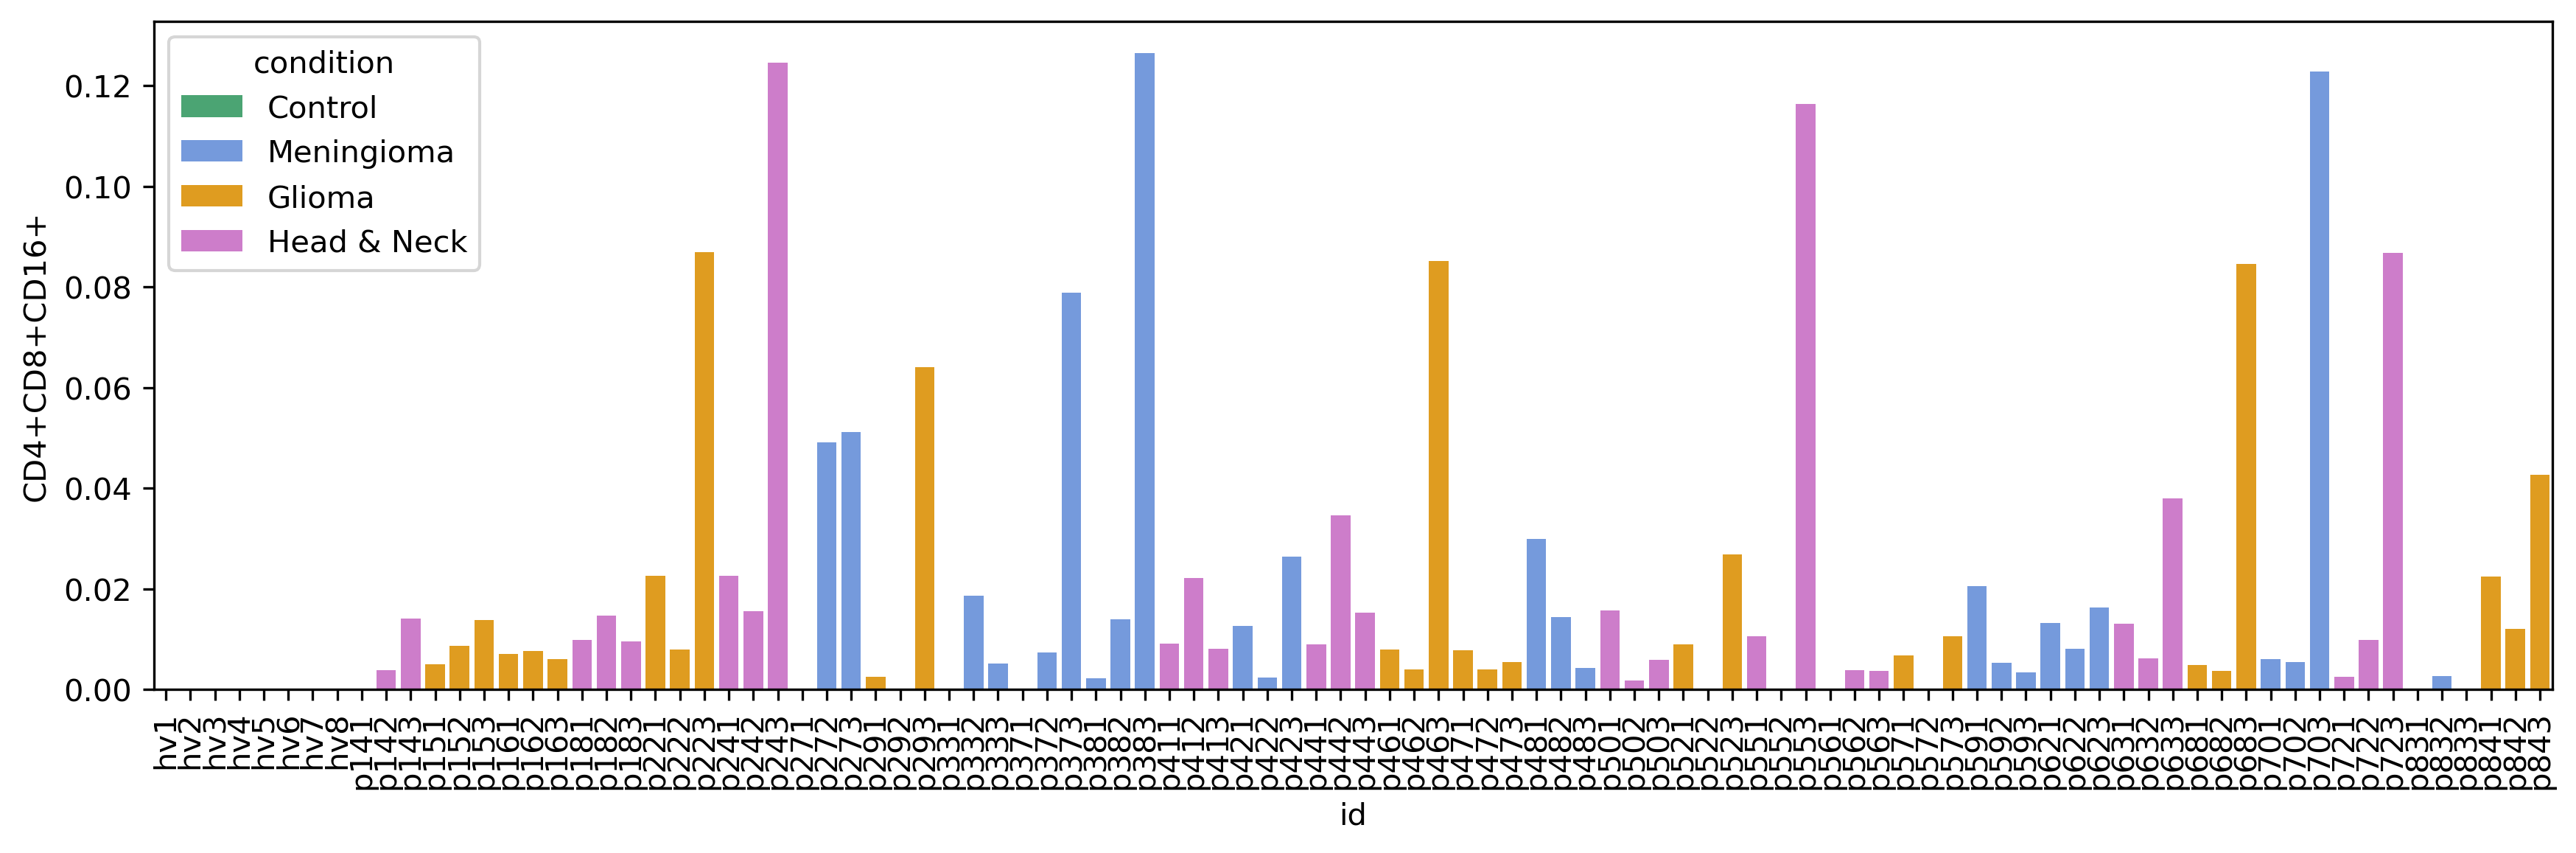

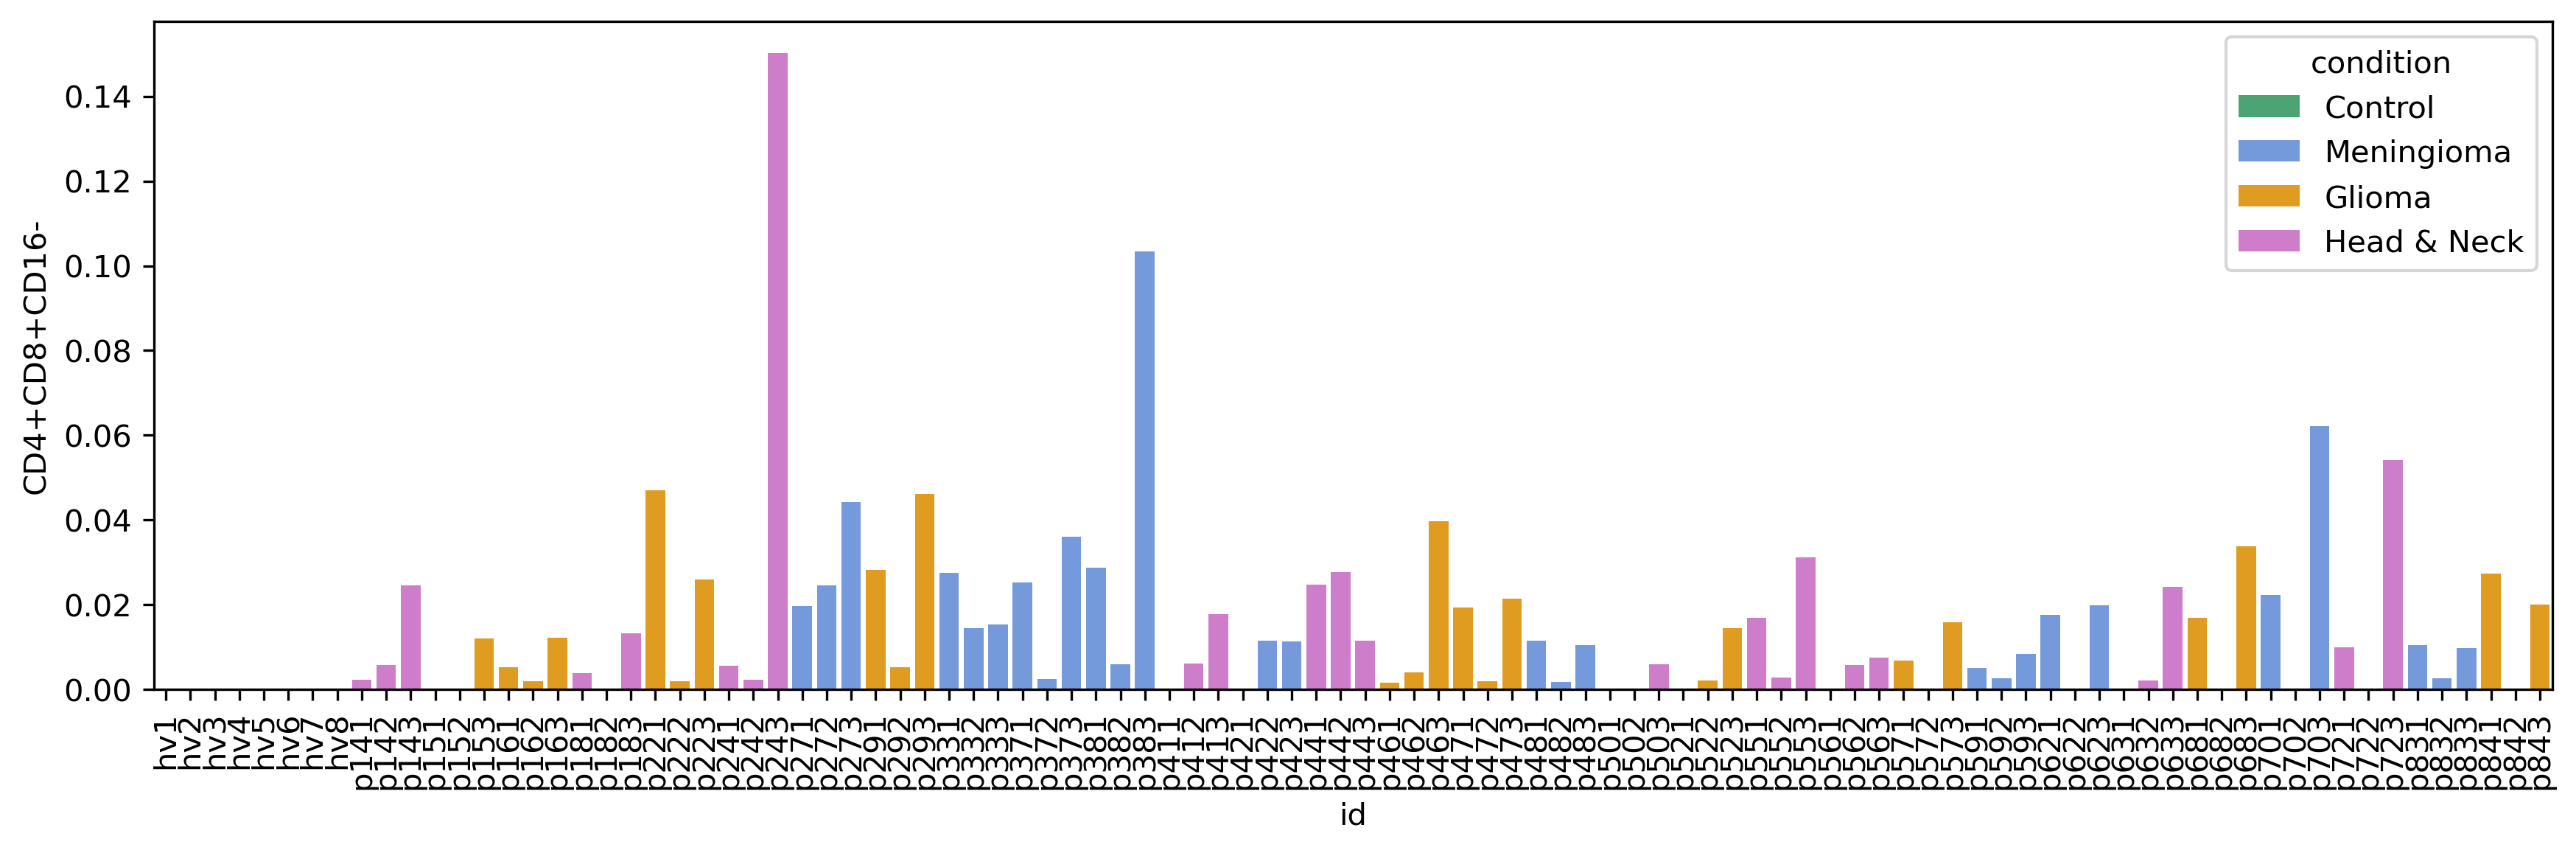

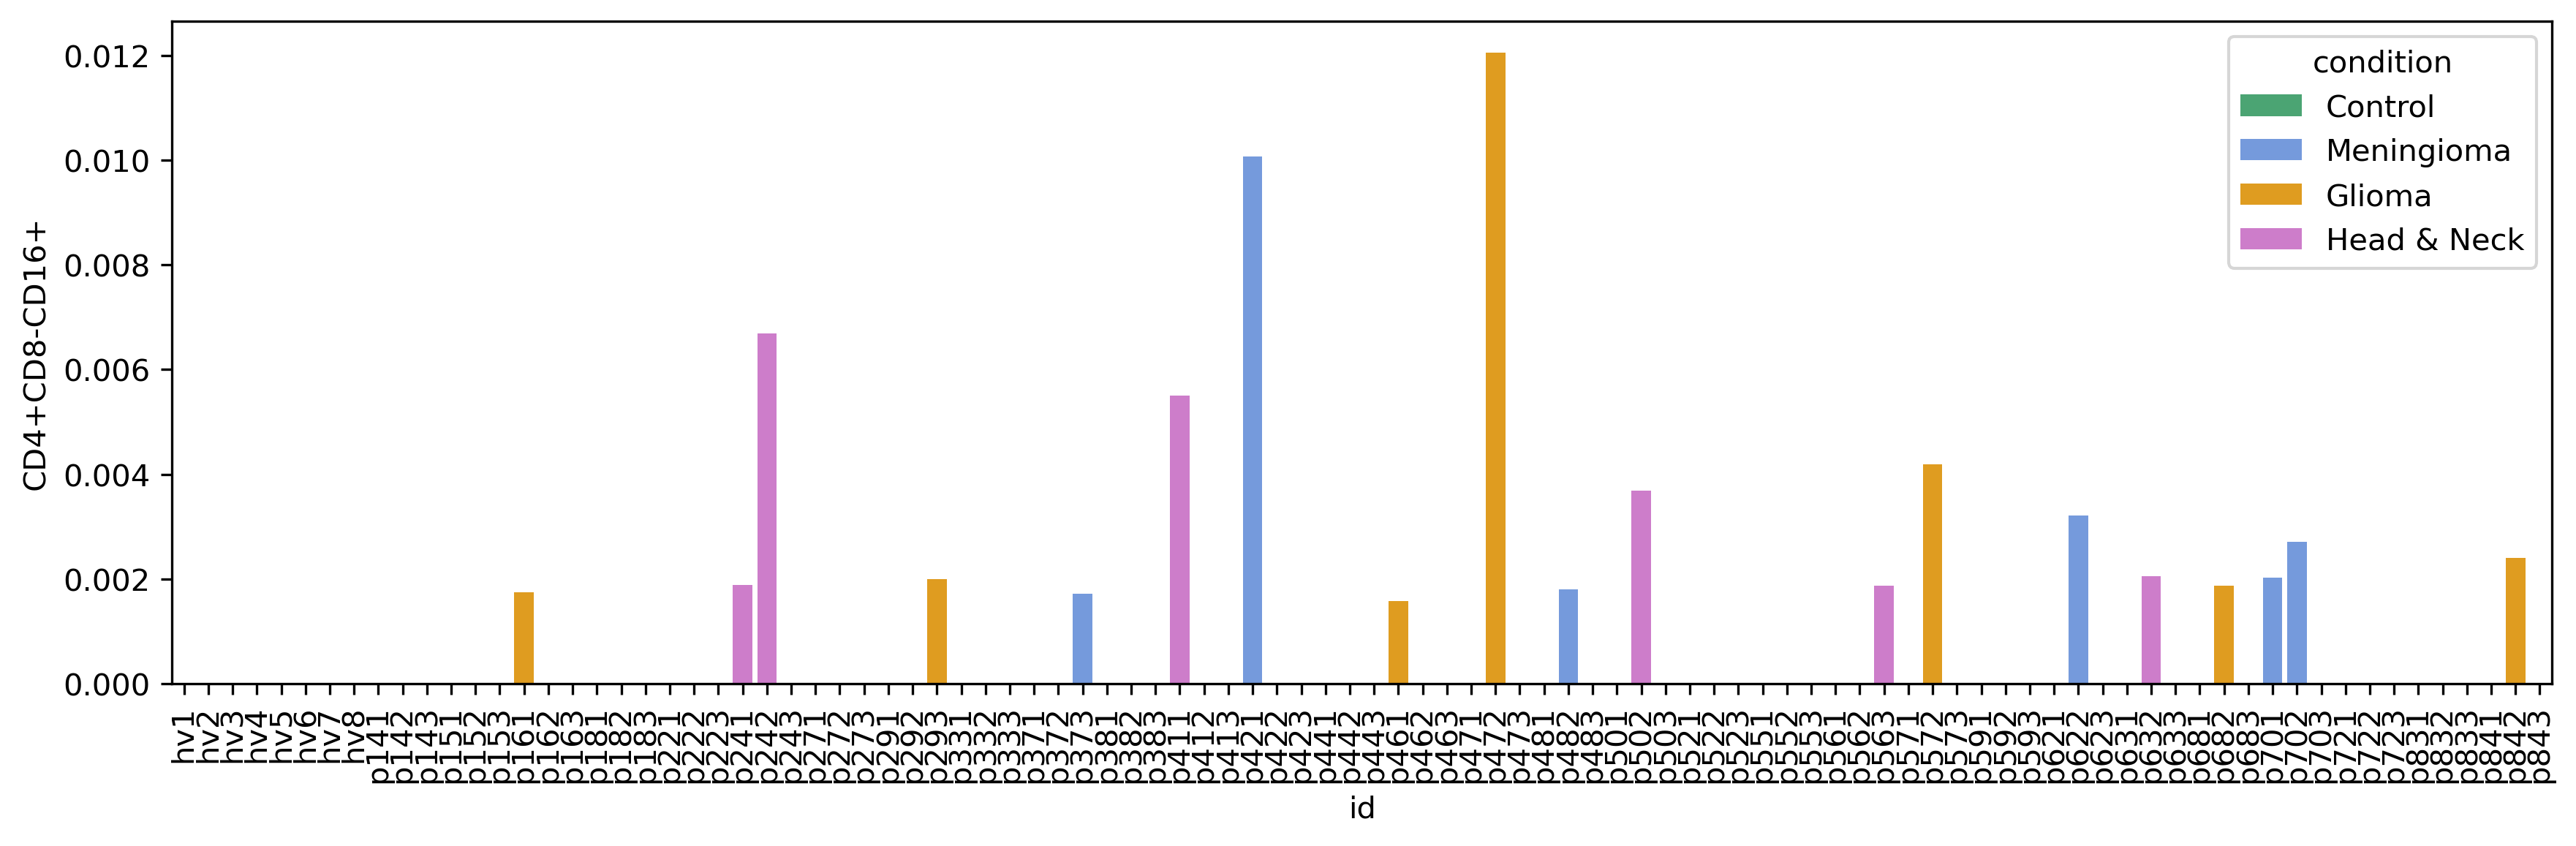

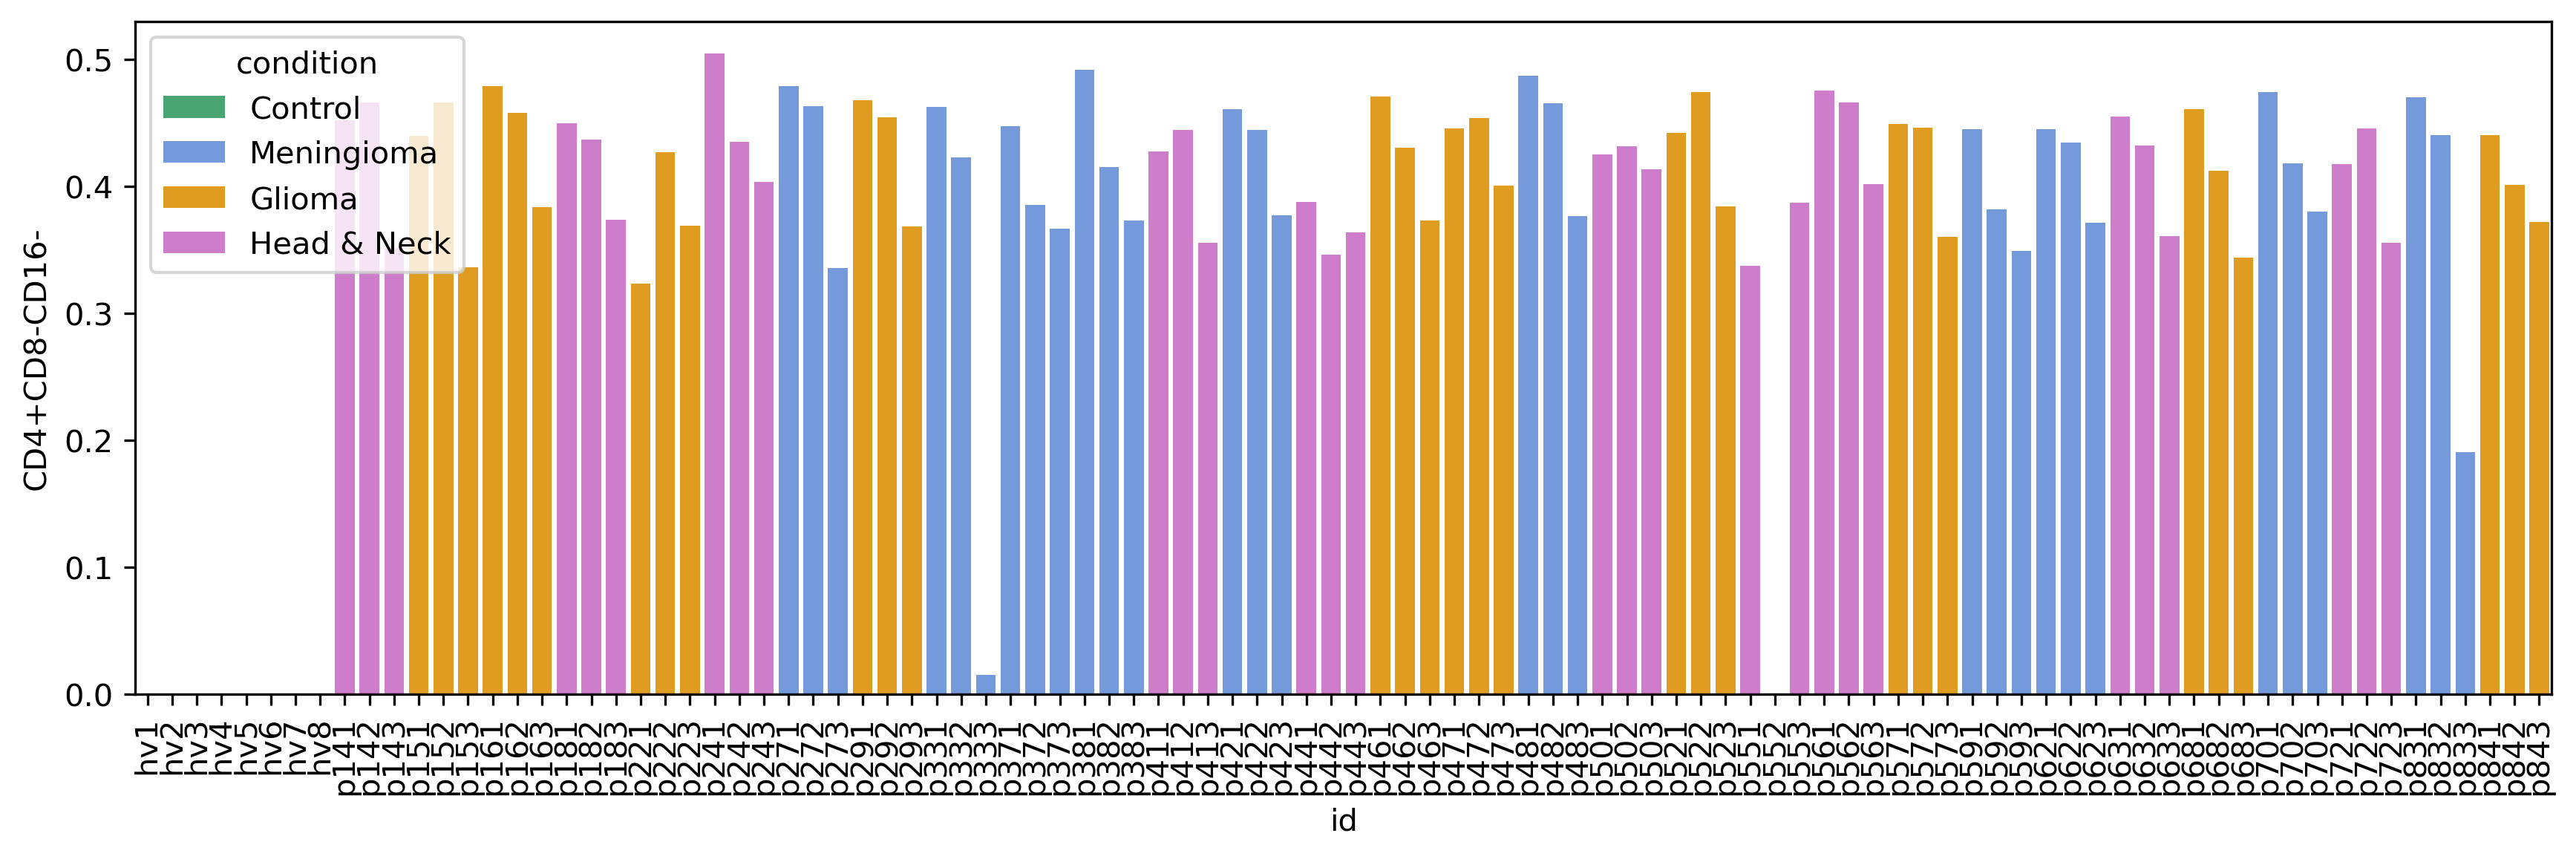

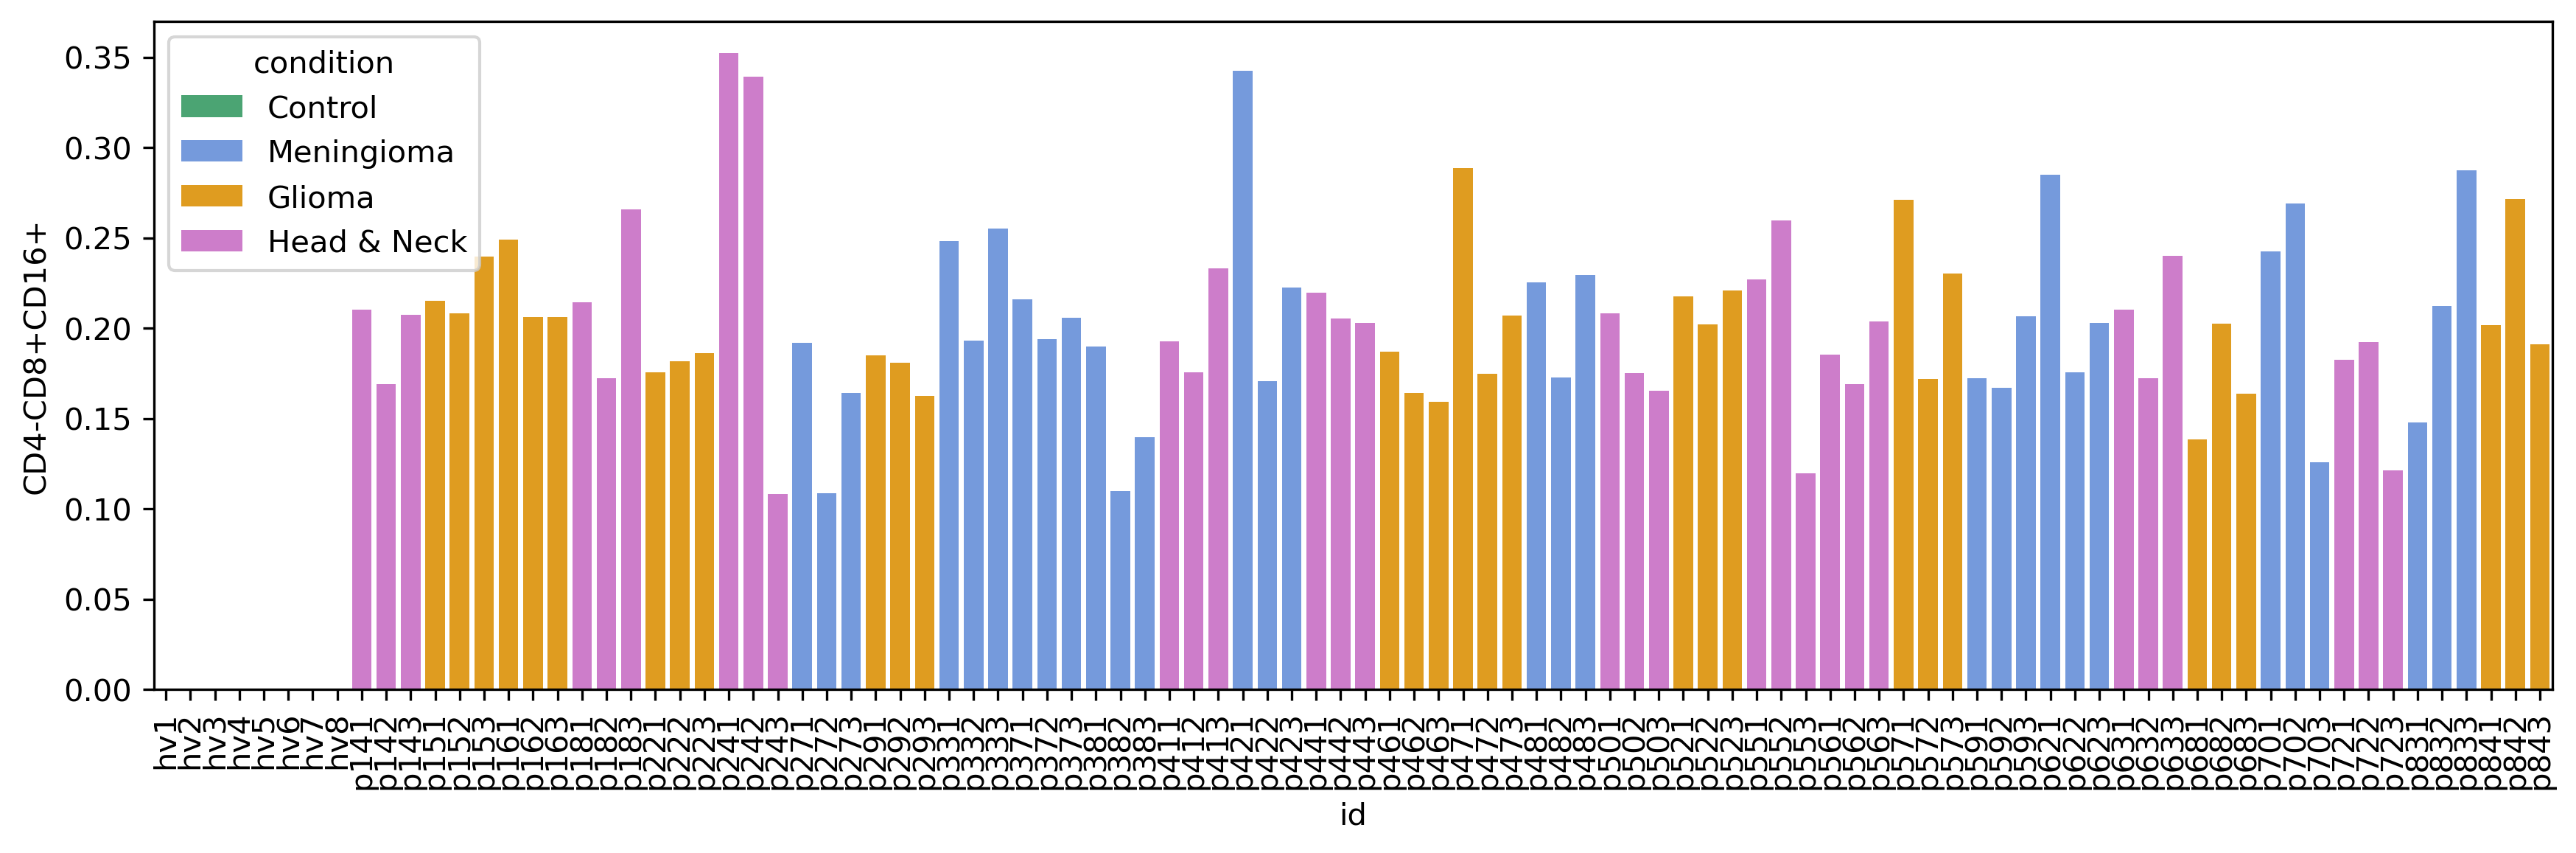

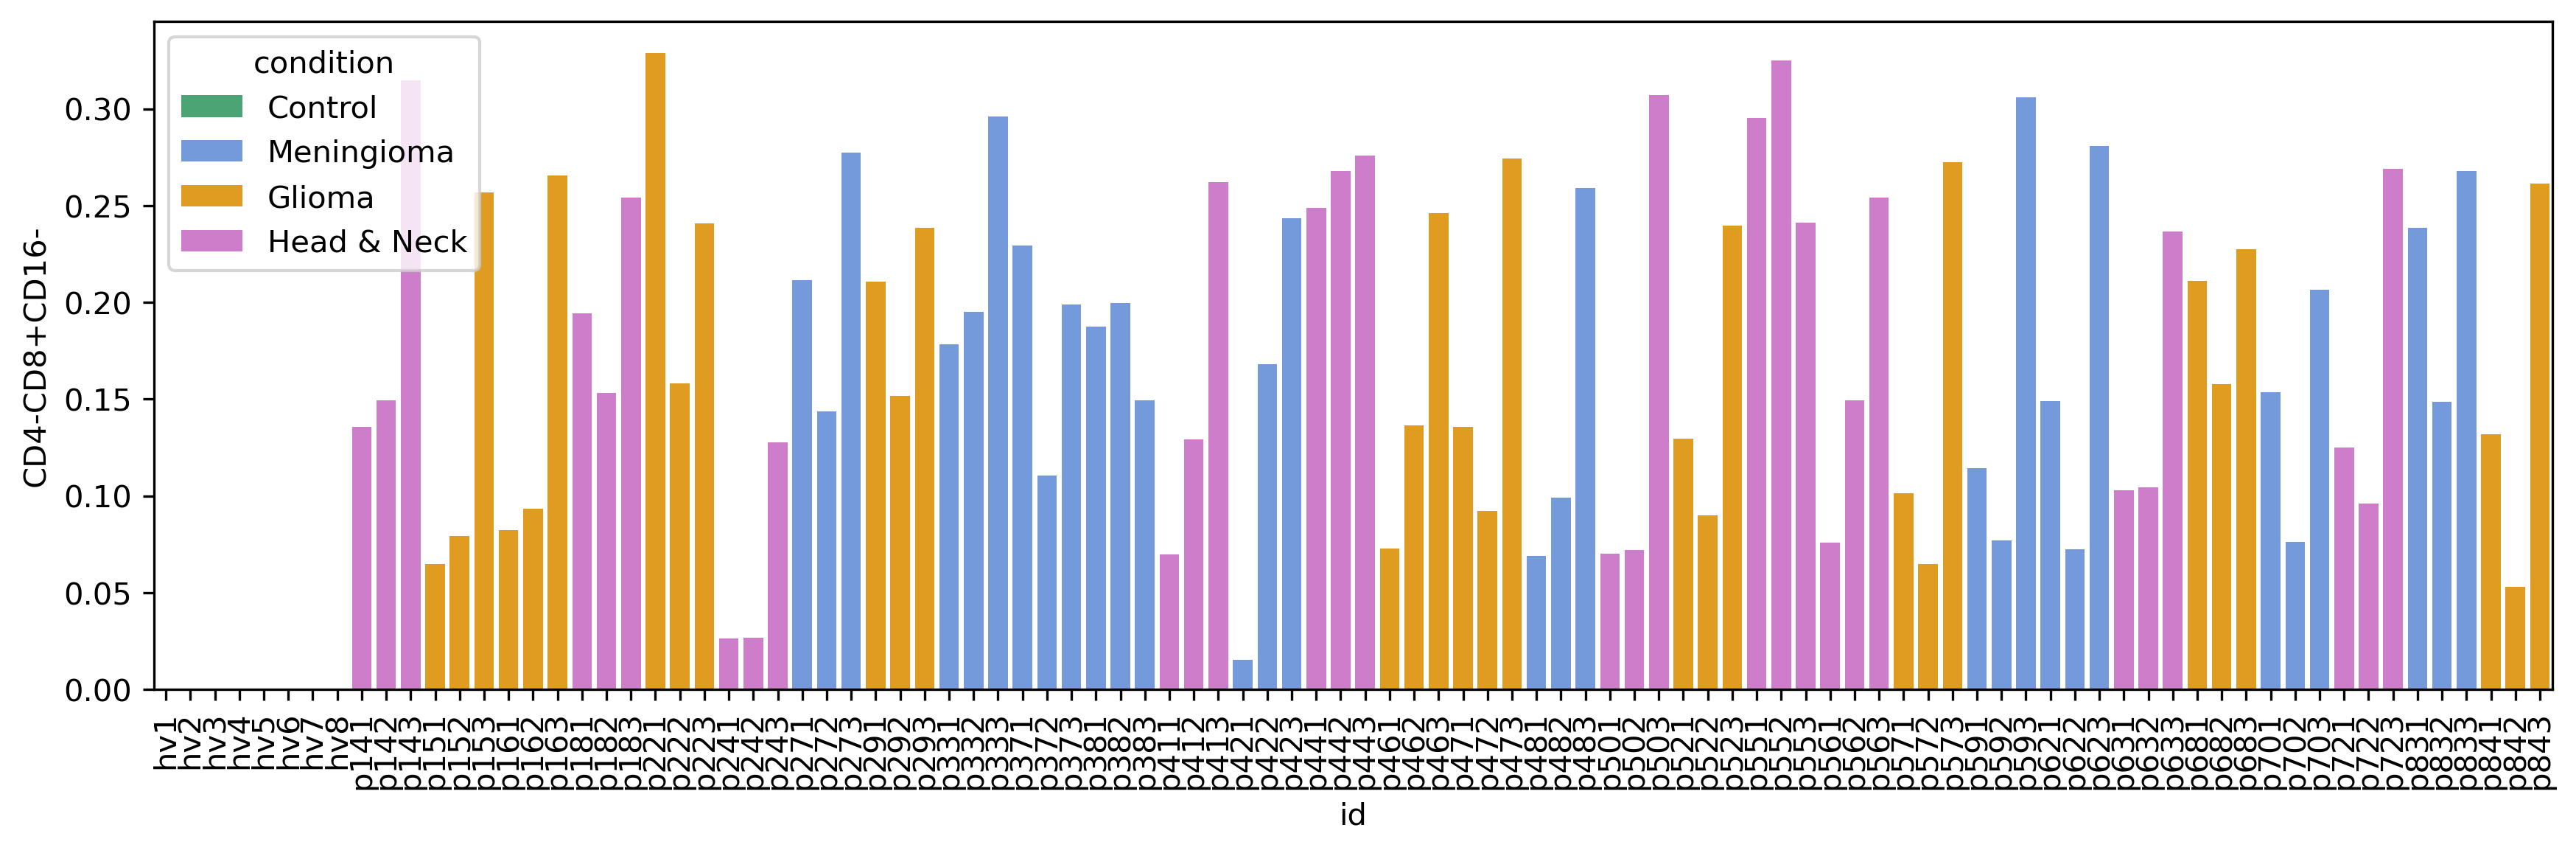

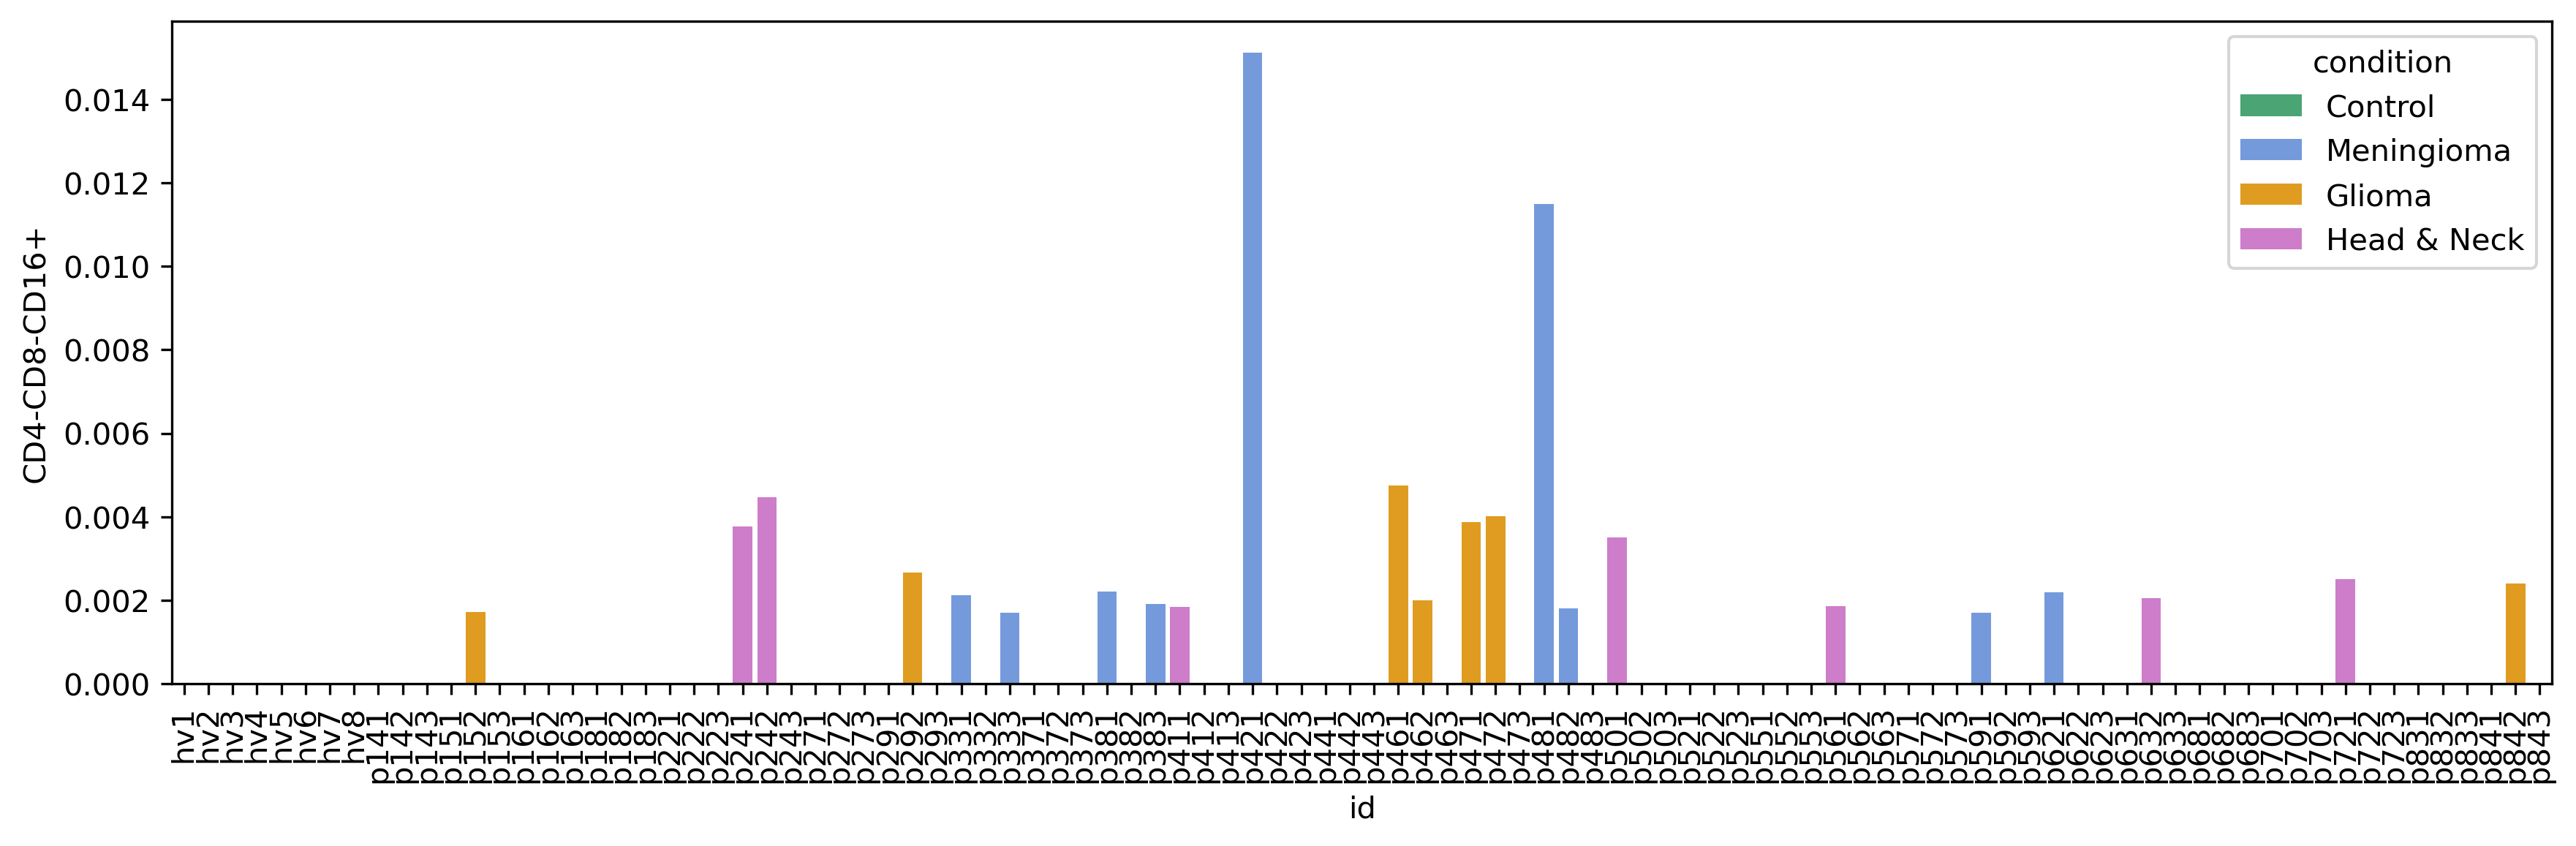

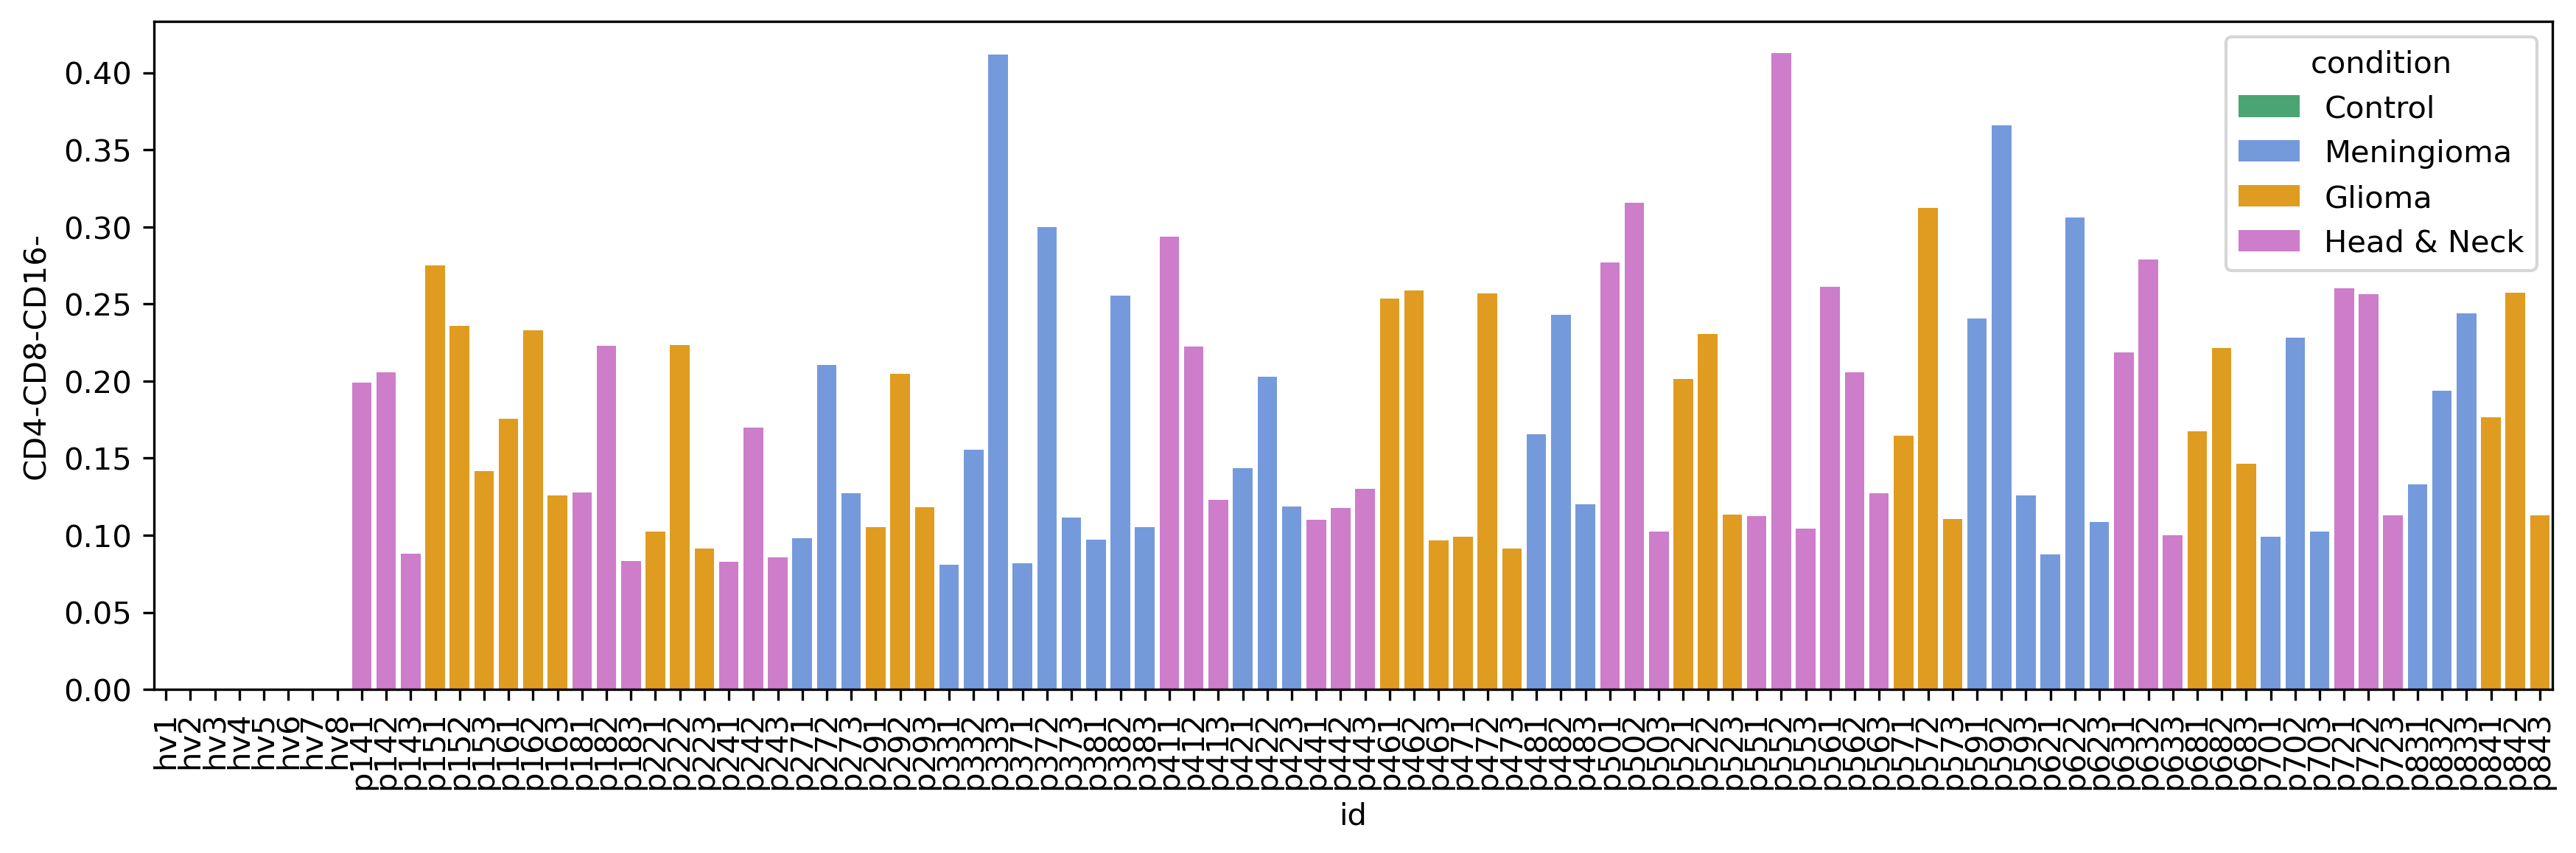

<IPython.core.display.Javascript object>

In [23]:
for celltype in celltypes_3:
    fig, ax = plt.subplots(figsize=[14, 4])
    ax = sns.barplot(
        data=ct_abundance_data,
        x="id",
        y=celltype,
        ax=ax,
        hue="condition",
        hue_order=list(cond_palette.keys()),
        palette=cond_palette,
        dodge=False,
    )
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

---

## 3. Panels

Now we generate the individual panels for figure 5 of the paper.

---

### 3b. Cell type abundancies changes during proton therapy treatment

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_during vs. Glioma_end: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.827e-04 U_stat=0.000e+00
Head & Neck_during vs. Head & Neck_end: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.130e-02 U_stat=1.600e+01
Meningioma_during vs. Meningioma_end: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.726e-02 U_stat=1.800e+01
Meningioma_prior vs. Meningioma_during: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.566e-02 U_stat=7.400e+01
Glioma_prior vs. Glioma_during: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.795e-03 U_stat=8.700e+01
Head & Neck_prior vs. Head & Neck_during: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correc

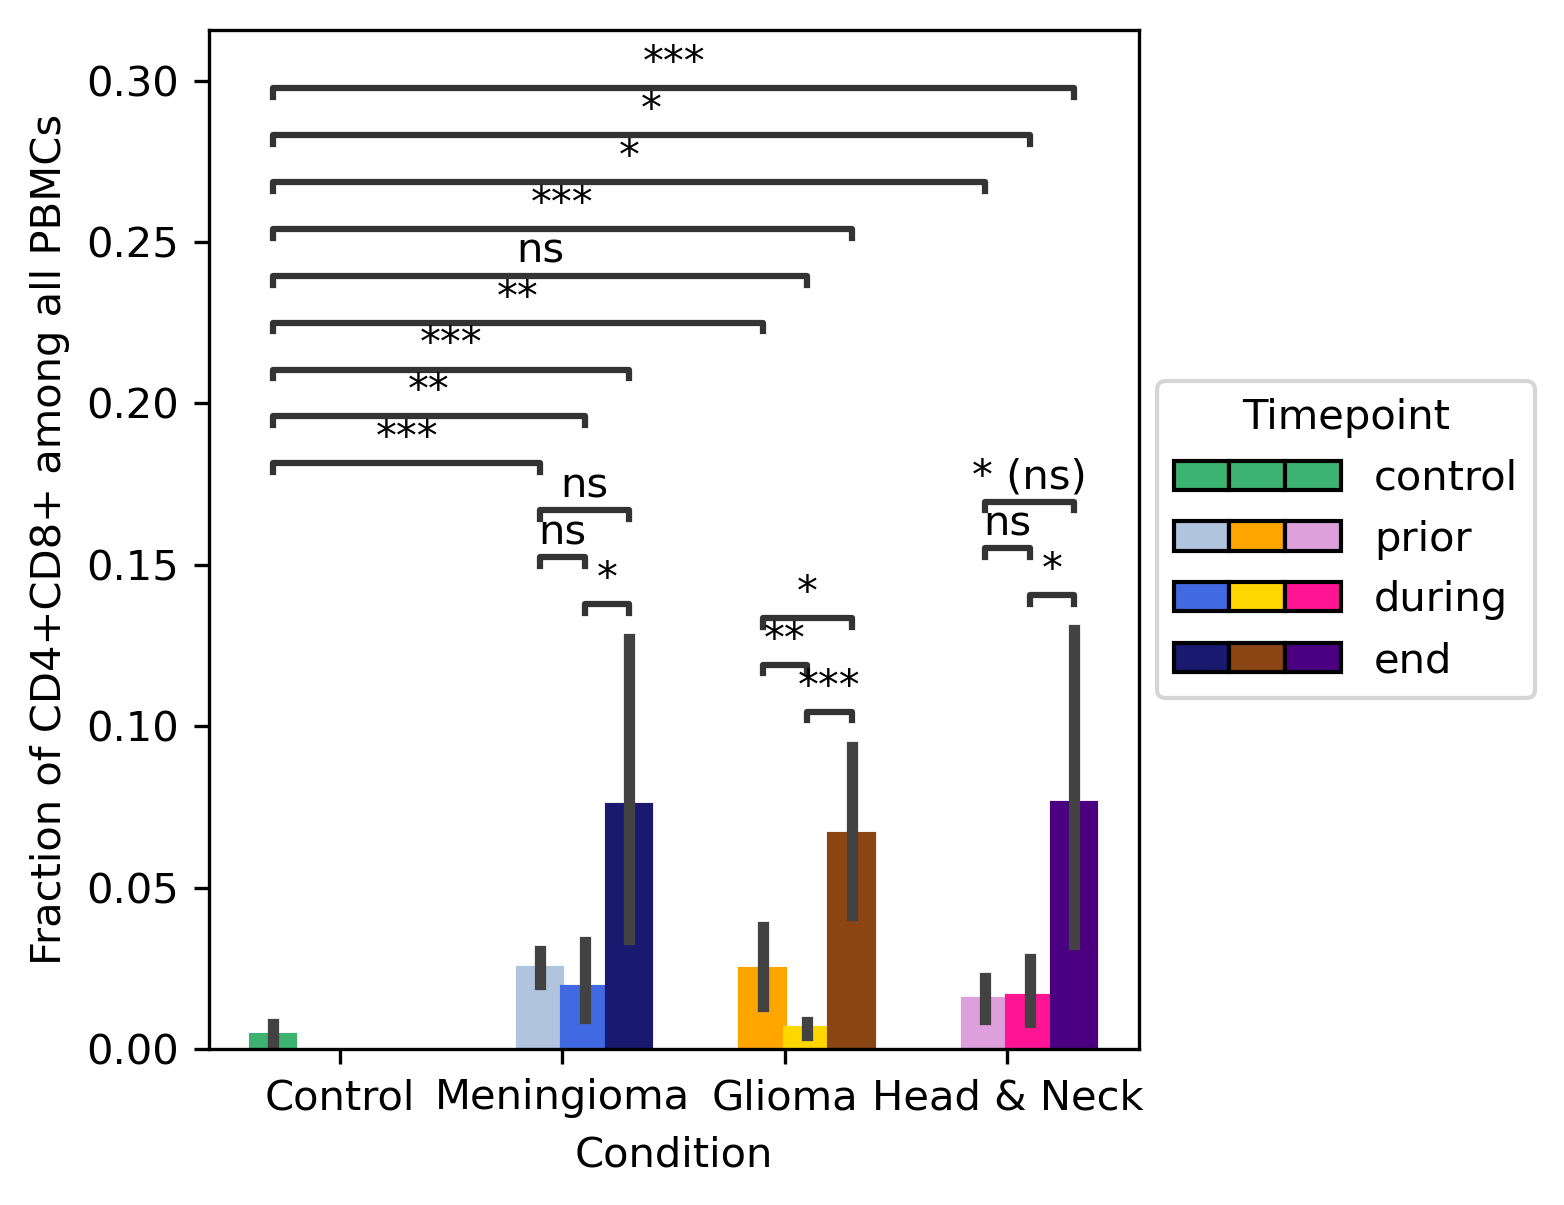

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_during vs. Glioma_end: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.827e-04 U_stat=1.000e+02
Head & Neck_during vs. Head & Neck_end: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.569e-02 U_stat=8.000e+01
Meningioma_during vs. Meningioma_end: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.827e-04 U_stat=1.000e+02
Meningioma_prior vs. Meningioma_during: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.706e-03 U_stat=9.200e+01
Glioma_prior vs. Glioma_during: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.337e-01 U_stat=5.500e+01
Head & Neck_prior vs. Head & Neck_during: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correc

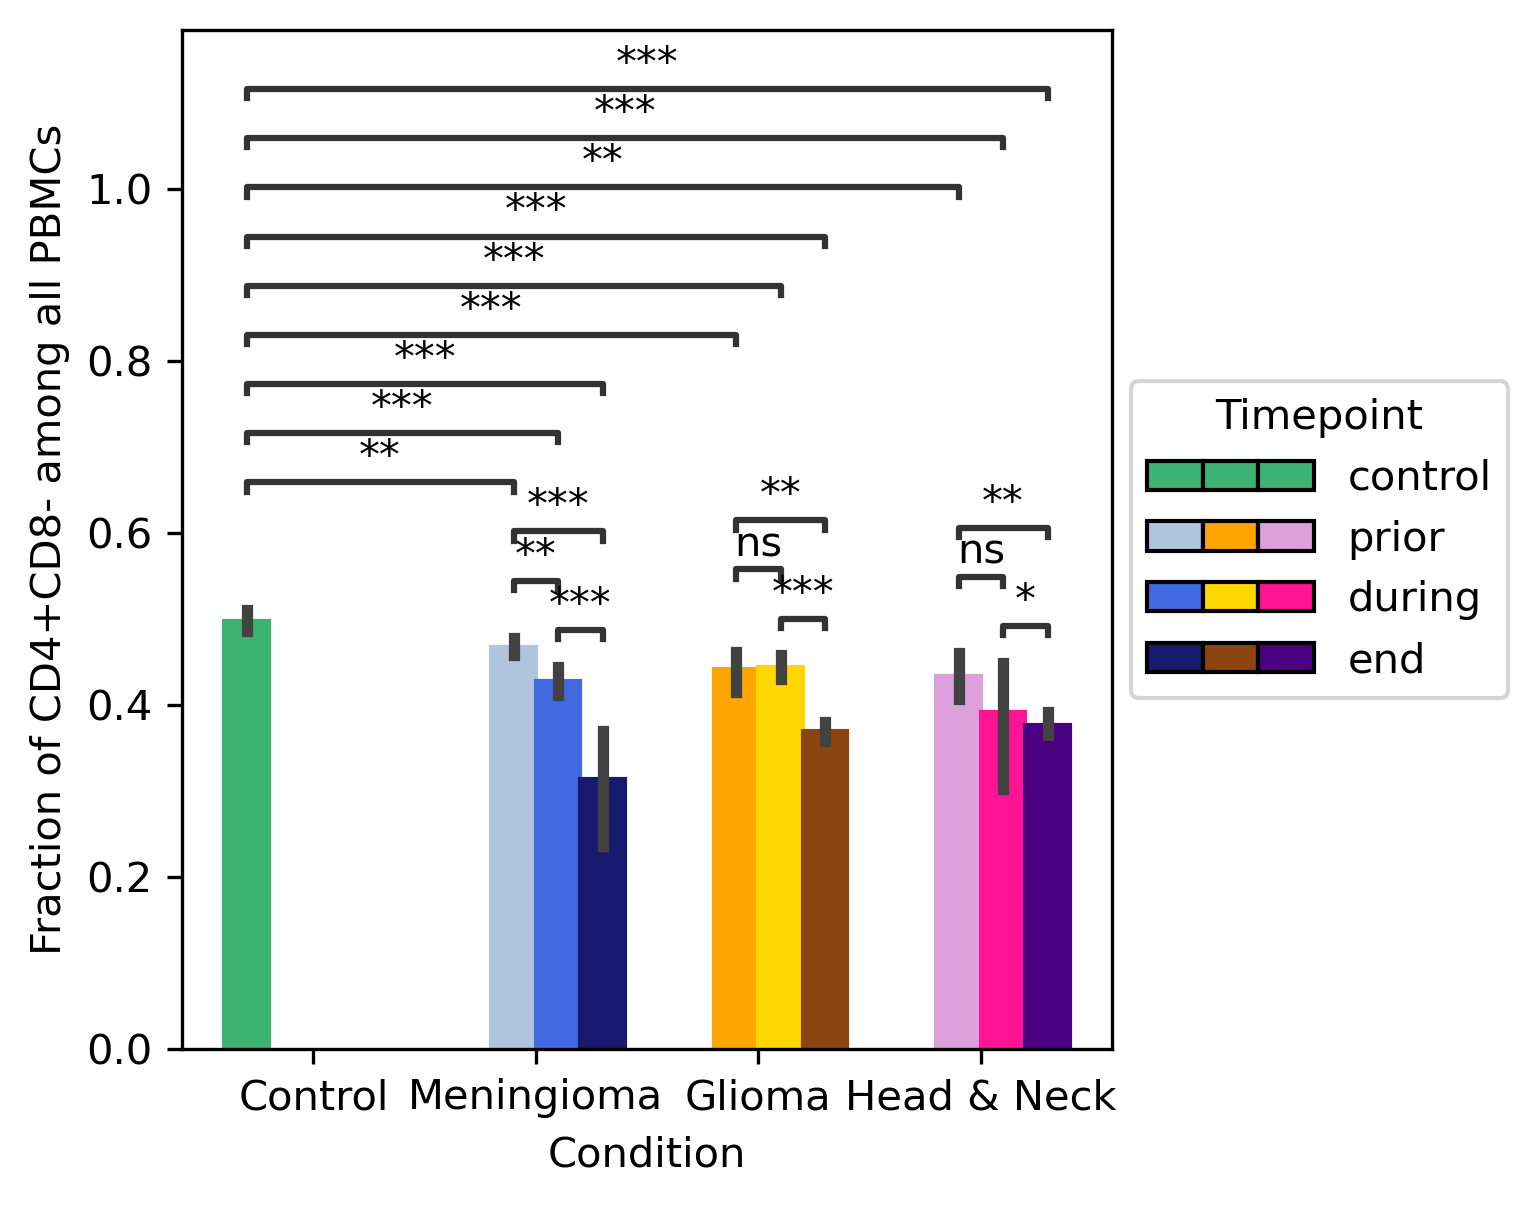

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_during vs. Glioma_end: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.827e-04 U_stat=0.000e+00
Head & Neck_during vs. Head & Neck_end: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.381e-02 U_stat=2.400e+01
Meningioma_during vs. Meningioma_end: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.827e-03 U_stat=1.000e+01
Meningioma_prior vs. Meningioma_during: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.133e-02 U_stat=8.400e+01
Glioma_prior vs. Glioma_during: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.390e-02 U_stat=7.600e+01
Head & Neck_prior vs. Head & Neck_during: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correc

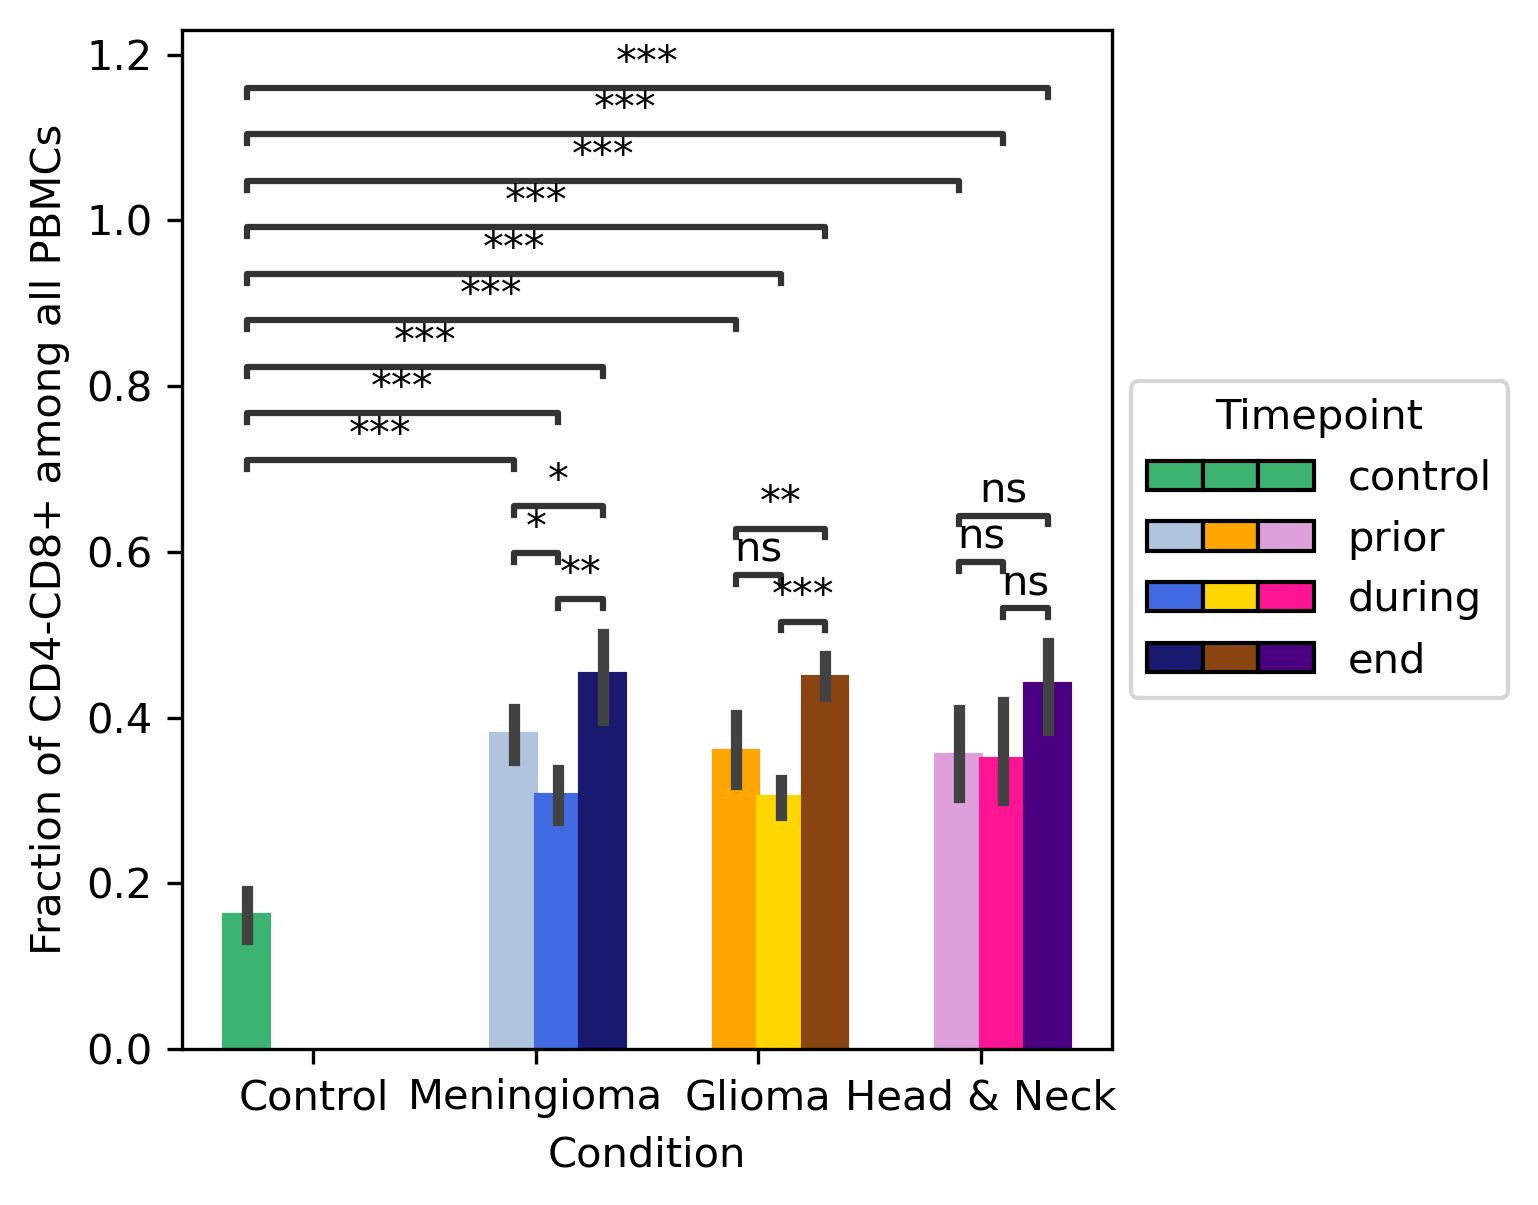

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glioma_during vs. Glioma_end: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.827e-04 U_stat=1.000e+02
Head & Neck_during vs. Head & Neck_end: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.375e-04 U_stat=9.700e+01
Meningioma_during vs. Meningioma_end: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.108e-03 U_stat=8.500e+01
Meningioma_prior vs. Meningioma_during: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.315e-03 U_stat=7.000e+00
Glioma_prior vs. Glioma_during: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.108e-03 U_stat=1.500e+01
Head & Neck_prior vs. Head & Neck_during: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correc

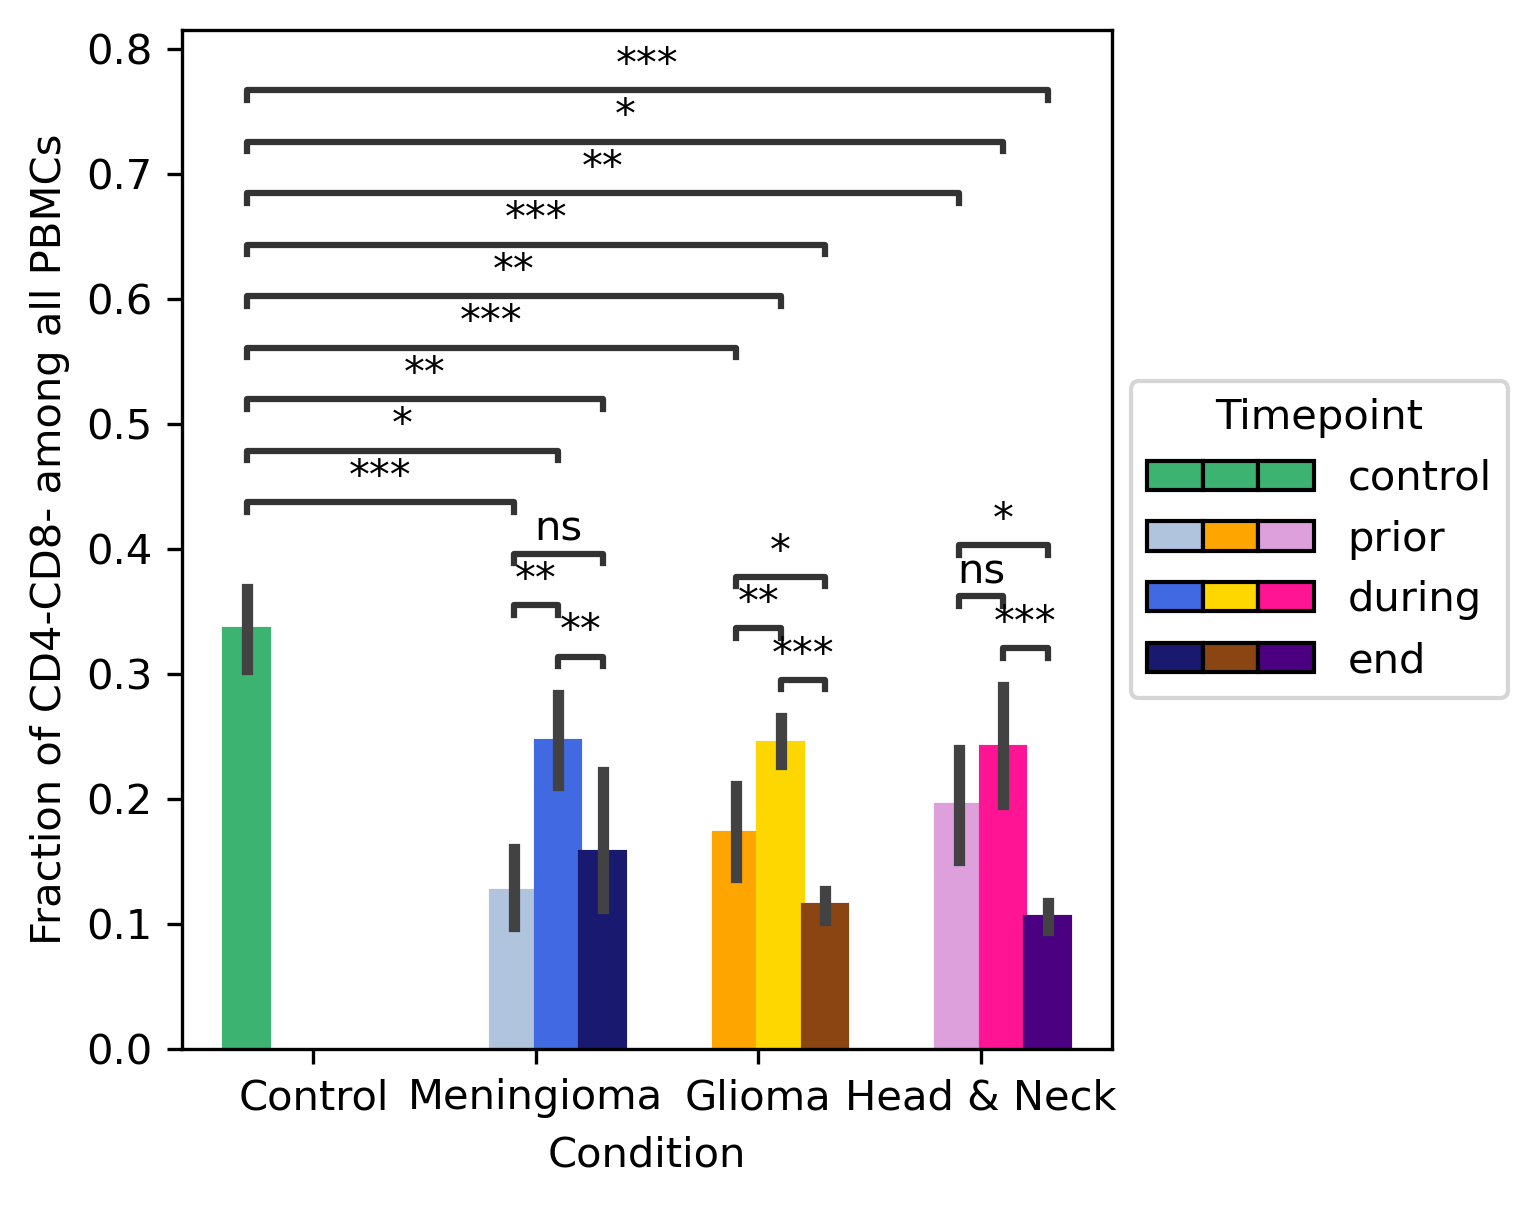

<IPython.core.display.Javascript object>

In [24]:
celltype2_labels = []
for celltype in celltypes_2:
    celltype2_labels.append("Fraction of {} among all PBMCs".format(celltype))

plot_celltype_abundancies_with_control(
    ct_abundance_data,
    celltypes=celltypes_2,
    celltype_labels=celltype2_labels,
    figsize=[4, 4.5],
    plot_type="bar",
)

In [25]:
celltype3_labels = []
for celltype in celltypes_3:
    celltype3_labels.append("Fraction of {} among all PBMCs".format(celltype))

plot_celltype_abundancies(
    ct_abundance_data,
    celltypes=celltypes_3,
    celltype_labels=celltype3_labels,
    figsize=[6, 6],
    plot_type="bar",
)

TypeError: plot_marker_distribution() got an unexpected keyword argument 'stat_annot'

<IPython.core.display.Javascript object>